# Generate a Mock Dataset

Generate a simulated TF dataset as follows:

* Merge the iron photometric + spectroscopic catalogs with the SGA2020 catalog.
* Apply all photometric corrections used in the TF analysis.
* Cross-match with one of the BGS mocks.
* Apply photometric and morphological cuts used in the PV survey for late-type galaxies.
* Generate mock rotational velocities using an inverted TFR best fit from the data.
* Generate mock TFR distances. 

In [2]:
import os
import shutil
import h5py
# import fitsio
import pickle
# import healpy as hp
import pandas as pd
import numpy as np
# import scipy as sp

from itertools import groupby

from csaps import csaps
# from scipy.interpolate import PchipInterpolator, UnivariateSpline
from scipy.stats import binned_statistic
from scipy.odr import ODR, Model, RealData
from scipy.spatial import KDTree

#- Global file path for PV analysis.
#  Set to the NERSC folder /global/cfs/cdirs/desi/science/td/pv by default.
#  Set it to something else if working offline.
pvpath = '/global/cfs/cdirs/desi/science/td/pv'
mockpath = os.path.join(pvpath, 'mocks')
tfmockpath = os.path.join(mockpath, 'TF_mocks')

from corner import corner

import sys
sys.path.append('/global/u1/k/kadglass/DESI_SGA/TF/')
from hyperfit.linfit import LinFit
from hyperfit_v2 import MultiLinFit
from line_fits import hyperfit_line_multi

#- Path to TF_mocks: code for Blanton's k-corrections.
import sys
sys.path.append(tfmockpath)
import TF_photoCorrect as tfpc

from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import Planck18, FlatLambdaCDM, units
from astropy.coordinates import SkyCoord, Distance

from tqdm import tqdm
from glob import glob

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
mpl.rc('font', size=11)

In [4]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

## Iron Data + SGA Catalog

Follow the procedure used in FP mock generation: read in iron data relevant for the TFR for cross-matching to the BGS mocks, producing a simulated set with realistic galaxy observables.

Here we merge the fullsweep and iron specprod catalogs to reproduce cuts when cross-matching with the mocks.

As a final step, get any missing SGA data directly from the SGA 2020 catalog.

In [5]:
#- Read in the iron fullsweep and specprod catalogs.
sw_keys = ['targetid', 'survey', 'program', 'healpix', 'target_ra', 'target_dec',
           'z', 'zerr', 'zwarn', 'inbasiccuts', 'has_corrupt_phot',
           'mag_g', 'mag_r', 'mag_z',
           'morphtype', 'sersic', 'BA_ratio',
           'circ_radius', 'circ_radius_err', 'uncor_radius', 'SGA_id', 'radius_SB25']

ironsweep = os.path.join(pvpath, 'redshift_data/Y1/iron_fullsweep_catalogue_z012.csv')
iron = pd.read_csv(ironsweep, usecols=sw_keys)

#- Read in the spectroscopic production table generated by Caitlin Ross.
sp_keys = ['targetid', 'survey', 'program', 'healpix',
           'mag_err_g', 'mag_err_r', 'mag_err_z', 
           'deltachi2']

ironspec = os.path.join(pvpath, 'redshift_data/Y1/specprod_iron_healpix_z015.csv')
ironsp = pd.read_csv(ironspec, usecols=sp_keys)

#- Cross-match the catalogs.
iron = pd.merge(iron, ironsp, 
                left_on=['targetid', 'survey', 'program', 'healpix'],
                right_on=['targetid', 'survey', 'program', 'healpix'], how='inner')

#- Object selection from the spectro pipeline:
#  1. Valid SGA ID, which implicitly enforces a size selection.
#  2. Delta-chi2 > 25.
#  3. No redrock warnings.
select = (iron['SGA_id'] > 0) & \
         (iron['deltachi2'] >= 25) & \
         (iron['zwarn'] == 0)

iron = iron.drop(iron[~select].index)

#- Read the SGA catalog and match on SGA_ID.
#  This is needed to access R_26 and other quantities at the mag 26 isophote.
sgafile = '/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits'
sgacat = Table.read(sgafile, 'ELLIPSE')
sgacat.rename_column('SGA_ID', 'SGA_id')
sgacat.rename_column('RA', 'SGA_ra')
sgacat.rename_column('DEC', 'SGA_dec')
sgacat = sgacat['SGA_ra', 'SGA_dec', 'SGA_id', 'D26', 'G_MAG_SB26', 'G_MAG_SB26_ERR', 'R_MAG_SB26', 'R_MAG_SB26_ERR', 'Z_MAG_SB26', 'Z_MAG_SB26_ERR'].to_pandas()
sgacat = sgacat.drop(sgacat[sgacat['R_MAG_SB26'] < 0].index)

iron = pd.merge(iron, sgacat, how='inner', on=['SGA_id'])

In [6]:
#- Drop NaN
iron = iron.dropna()
iron

survey program  healpix           targetid  target_dec   target_ra  \
0         sv1  bright    34723  39627082556248187  -30.586432   58.890261   
1         sv1  bright    34725  39627082589804885  -30.509964   61.244826   
2         sv1  bright    34703  39627082593998226  -30.408004   61.518464   
3         sv1  bright    34729  39627087765574578  -30.251105   58.278362   
4         sv1  bright    34729  39627087773962063  -30.188369   58.780902   
...       ...     ...      ...                ...         ...         ...   
102514   main    dark     7975   2852649649045504   72.895711  131.867353   
102515   main    dark     7973   2852649653239808   72.926464  133.218536   
102516   main    dark     8034   2852673590132736   76.634771  140.593982   
102517    sv3  bright    11604  39633456283519525   66.170195  266.658931   
102518    sv3    dark    11604  39633456283519525   66.170195  266.658931   

               z          zerr  zwarn morphtype  ...  mag_err_r      SGA_ra  \
0       0.093327  1.755050e-05      0       SER  ...   0.000430   58.890261   
1       0.058229  3.289745e-06      0       SER  ...   0.000833   61.244826   
2       0.059050  2.278493e-06      0       SER  ...   0.000355   61.518464   
3       0.081022  1.363088e-05      0       SER  ...   0.001176   58.278362   
4       0.096937  1.941603e-05      0       SER  ...   0.000785   58.780902   
...          ...           ...    ...       ...  ...        ...         ...   
102514  0.011291  7.328162e-06      0       DEV  ...   0.000785  131.867353   
102515  0.012603  7.566643e-07      0       DEV  ...   0.000462  133.218536   
102516  0.076971  4.815062e-06      0       SER  ...   0.001131  140.593982   
102517  0.117068  1.531648e-05      0       SER  ...   0.001742  266.658931   
102518  0.117098  8.208770e-06      0       SER  ...   0.001742  266.658931   

          SGA_dec       D26  G_MAG_SB26  G_MAG_SB26_ERR  R_MAG_SB26  \
0      -30.586432  0.575315   17.063408        0.034668   16.134380   
1      -30.509964  0.398020   17.159575        0.005541   16.691721   
2      -30.408004  0.998481   16.092411        0.024773   15.328482   
3      -30.251105  0.427528   18.176348        0.028036   17.460354   
4      -30.188369  0.648811   17.540487        0.039971   16.529564   
...           ...       ...         ...             ...         ...   
102514  72.895711  0.841495   16.188450        0.005690   15.252360   
102515  72.926464  1.141312   15.233910        0.016896   14.147840   
102516  76.634771  0.515602   16.521830        0.005591   15.891319   
102517  66.170195  0.686332   16.746572        0.019684   16.290340   
102518  66.170195  0.686332   16.746572        0.019684   16.290340   

        R_MAG_SB26_ERR  Z_MAG_SB26  Z_MAG_SB26_ERR  
0             0.038069   15.478448        0.039409  
1             0.005926   16.403215        0.006768  
2             0.026500   14.777832        0.026026  
3             0.029271   16.949606        0.031180  
4             0.041773   15.713690        0.042567  
...                ...         ...             ...  
102514        0.006012   14.736343        0.008489  
102515        0.015995   13.483636        0.021117  
102516        0.005790   15.526414        0.006989  
102517        0.016576   16.699310        0.030471  
102518        0.016576   16.699310        0.030471  

[93971 rows x 35 columns]

### Keep only Galaxy Centers

The iron catalog may include some off-axis measurements of SGA galaxies that pass the spectroscopic cuts. Remove them with a cone-angle cut, comparing the SGA centers (from Tractor) to the target RA, Dec in DESI. The cut is

$$
\frac{\angle(\mathbf{r}_\mathrm{SGA}, \mathbf{r}_\mathrm{fiber})}{D_{26}/2} < 0.1
$$

See details in Kelly's [SGA selection notebook for iron](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/iron_rot_vel.ipynb).

Note that requiring a nonzero $m_{r,\mathrm{SB_{26}}}$ may remove all spectra not measured on galaxy centers, making this cut redundant.

In [7]:
coords_sga = SkyCoord(ra=iron['SGA_ra'], dec=iron['SGA_dec'], unit='degree')
coords_iron = SkyCoord(ra=iron['target_ra'], dec=iron['target_dec'], unit='degree')
sep2d = coords_iron.separation(coords_sga)
select = (2*sep2d.to_value('arcmin') / iron['D26']) < 0.1

iron = iron.drop(iron[~select].index)

In [8]:
iron

survey program  healpix           targetid  target_dec   target_ra  \
0         sv1  bright    34723  39627082556248187  -30.586432   58.890261   
1         sv1  bright    34725  39627082589804885  -30.509964   61.244826   
2         sv1  bright    34703  39627082593998226  -30.408004   61.518464   
3         sv1  bright    34729  39627087765574578  -30.251105   58.278362   
4         sv1  bright    34729  39627087773962063  -30.188369   58.780902   
...       ...     ...      ...                ...         ...         ...   
102514   main    dark     7975   2852649649045504   72.895711  131.867353   
102515   main    dark     7973   2852649653239808   72.926464  133.218536   
102516   main    dark     8034   2852673590132736   76.634771  140.593982   
102517    sv3  bright    11604  39633456283519525   66.170195  266.658931   
102518    sv3    dark    11604  39633456283519525   66.170195  266.658931   

               z          zerr  zwarn morphtype  ...  mag_err_r      SGA_ra  \
0       0.093327  1.755050e-05      0       SER  ...   0.000430   58.890261   
1       0.058229  3.289745e-06      0       SER  ...   0.000833   61.244826   
2       0.059050  2.278493e-06      0       SER  ...   0.000355   61.518464   
3       0.081022  1.363088e-05      0       SER  ...   0.001176   58.278362   
4       0.096937  1.941603e-05      0       SER  ...   0.000785   58.780902   
...          ...           ...    ...       ...  ...        ...         ...   
102514  0.011291  7.328162e-06      0       DEV  ...   0.000785  131.867353   
102515  0.012603  7.566643e-07      0       DEV  ...   0.000462  133.218536   
102516  0.076971  4.815062e-06      0       SER  ...   0.001131  140.593982   
102517  0.117068  1.531648e-05      0       SER  ...   0.001742  266.658931   
102518  0.117098  8.208770e-06      0       SER  ...   0.001742  266.658931   

          SGA_dec       D26  G_MAG_SB26  G_MAG_SB26_ERR  R_MAG_SB26  \
0      -30.586432  0.575315   17.063408        0.034668   16.134380   
1      -30.509964  0.398020   17.159575        0.005541   16.691721   
2      -30.408004  0.998481   16.092411        0.024773   15.328482   
3      -30.251105  0.427528   18.176348        0.028036   17.460354   
4      -30.188369  0.648811   17.540487        0.039971   16.529564   
...           ...       ...         ...             ...         ...   
102514  72.895711  0.841495   16.188450        0.005690   15.252360   
102515  72.926464  1.141312   15.233910        0.016896   14.147840   
102516  76.634771  0.515602   16.521830        0.005591   15.891319   
102517  66.170195  0.686332   16.746572        0.019684   16.290340   
102518  66.170195  0.686332   16.746572        0.019684   16.290340   

        R_MAG_SB26_ERR  Z_MAG_SB26  Z_MAG_SB26_ERR  
0             0.038069   15.478448        0.039409  
1             0.005926   16.403215        0.006768  
2             0.026500   14.777832        0.026026  
3             0.029271   16.949606        0.031180  
4             0.041773   15.713690        0.042567  
...                ...         ...             ...  
102514        0.006012   14.736343        0.008489  
102515        0.015995   13.483636        0.021117  
102516        0.005790   15.526414        0.006989  
102517        0.016576   16.699310        0.030471  
102518        0.016576   16.699310        0.030471  

[93971 rows x 35 columns]

## Apply Dust and K-corrections

There are four photometric corrections that need to be applied.

1. N vs. S imaging catalog photometric systematics.
2. $k$-corrections to $z=0.1$.
3. Global Milky Way dust corrections using the maps from Zhou+, 2024.
4. Per-galaxy internal dust corrections based on the galaxies' inclination angles.

The corrections, applied to the $r$-band magnitudes, are summed as

$$
A_\mathrm{sys} + A_k + A_\mathrm{MW} + A_\mathrm{dust}
$$

### Imaging Systematics

In [9]:
#- Apply imaging survey systematics: compute photometric system (N or S)
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
c = SkyCoord(iron['target_ra'], iron['target_dec'], unit='degree')
isnorth = (c.galactic.b > 0) & (iron['target_dec'] > 32.375)
iron['photsys'] = 'S'
iron.loc[isnorth, 'photsys'] = 'N'

#- Adjust northern photometry to DECaLS
Asys, Asys_err = tfpc.BASS_corr(iron['photsys'])

### K Correction

In [10]:
#- This is based on the kcorrect package by Blanton (https://kcorrect.readthedocs.io/)
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
select = iron['z'] > 0

kc = tfpc.k_corr(iron['z'][select], 
                [iron['G_MAG_SB26'][select],     iron['R_MAG_SB26'][select],     iron['Z_MAG_SB26'][select]], 
                [iron['G_MAG_SB26_ERR'][select], iron['R_MAG_SB26_ERR'][select], iron['Z_MAG_SB26_ERR'][select]], 
                z_corr=0.1)

Ak = np.zeros((len(iron), 3))
Ak[select] = kc

### MW Dust Correction

In [11]:
#- Compute MW dust corrections
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
dustmap = '/global/cfs/cdirs/desi/public/papers/mws/desi_dust/y2/v1/maps/desi_dust_gr_512.fits'
ebv = Table.read(dustmap)
Adust, Adust_err = tfpc.MW_dust(iron['target_ra'].values, iron['target_dec'].values, ebv)

#- Mask out NaNs
for i, band in enumerate('grz'):
    isnan_gal = np.isnan(Adust[i])
    if np.any(isnan_gal):
        logging.info(f'Removing NaN for MW dust correction, band {band}')
        Adust[i][isnan_gal] = 0
        Adust_err[i][isnan_gal] = 0

/global/u1/k/kadglass/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


### Apply MW, K-Correction, and Imaging Systematics Corrections Prior to Internal Dust Correction

In [12]:
#- Apply MW dust, k-corrections, and photometric systematic corrections to the data.
for i, band in enumerate('GRZ'):
    iron[f'{band}_MAG_SB26_tmp'] = iron[f'{band}_MAG_SB26'] - Adust[i] + Asys + Ak[:,i]
    iron[f'{band}_MAG_SB26_ERR_tmp'] = np.sqrt(iron[f'{band}_MAG_SB26_ERR']**2 + Adust_err[i]**2 + Asys_err**2)

### Internal Dust Correction 

Correct m_r for the internal galactic dust, assuming that as we look through higher inclinations we're viewing the galaxy through its dust lanes. Details in [this notebook by Kelly](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/TF_iron_internal-dustCorr.ipynb).

Best fit:     [-1.37475514  0.75256222]
uncertainty:  [0.08632504 0.04738354]


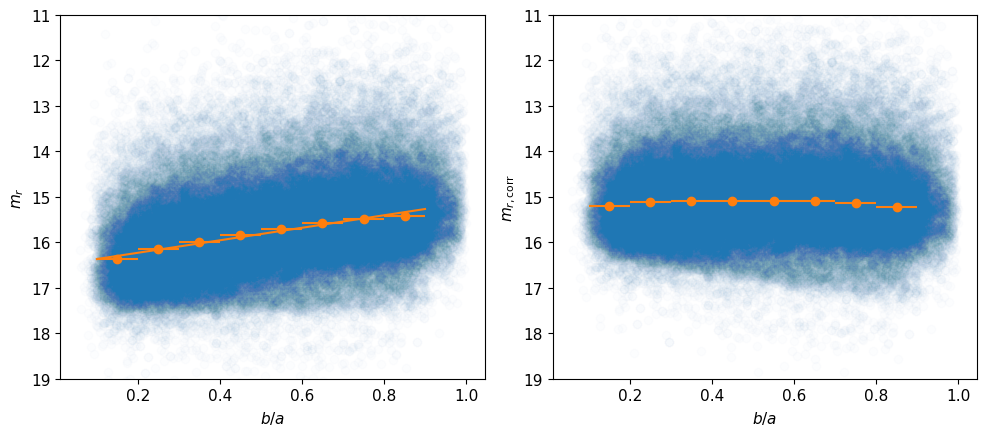

In [13]:
#- Kelly applies an empirical fit to the internal dust in each galaxy. Steps:
#   1. Apply "known" corrections (k-correction, MW dust).
#   2. Fit m_r_corr (corrected) vs spiral b/a
#   3. Zero out this linear dependence.

#- Set up a binned data set and perform the fit
ba_bins = np.arange(0.1,1,0.1)
ba = 0.5*(ba_bins[1:] + ba_bins[:-1])
ba_err = 0.5*np.diff(ba_bins)
m_r_median = np.median(iron['R_MAG_SB26_tmp'])
m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='median', bins=ba_bins)
n_bin, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='count', bins=ba_bins)
m_r_err, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='std', bins=ba_bins)
m_r_err /= np.sqrt(n_bin)

linear_fit = lambda coeff, x: coeff[0]*x + coeff[1]
model = Model(linear_fit)
data = RealData(ba, m_r - m_r_median, sx=ba_err, sy=m_r_err)
odr = ODR(data, model, beta0=[1, 1])

result = odr.run()
coeff = result.beta
coeff_err = result.sd_beta
print('Best fit:    ', coeff)
print('uncertainty: ', coeff_err)

fig, axes = plt.subplots(1,2, figsize=(10,4.5), tight_layout=True, sharex=True)#, sharey=True)
ax = axes[0]
ax.scatter(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], alpha=0.01)
ax.errorbar(ba, m_r, xerr=ba_err, yerr=m_r_err, fmt='o', color='tab:orange')
ax.plot(ba_bins, coeff[0]*ba_bins + coeff[1] + m_r_median, color='tab:orange')
ax.set(ylim=(19, 11),
       ylabel='$m_{r}$',
       xlabel='$b/a$');

#- Compute the internal dust correction
A_int, A_int_err = tfpc.internal_dust(iron['BA_ratio'].values, coeff, coeff_err)

ax = axes[1]
ax.scatter(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int, alpha=0.01)
m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int, statistic='median', bins=ba_bins)
ax.errorbar(ba, m_r, xerr=ba_err, yerr=m_r_err, fmt='o', color='tab:orange')
ax.set(ylim=(19, 11),
       ylabel='$m_{r,\mathrm{corr}}$',
       xlabel='$b/a$')

# fig.savefig('tfr_mock_internal_dust_correction.png', dpi=150);

#- Update the r-band magnitudes
iron['R_MAG_SB26_CORR'] = iron['R_MAG_SB26_tmp'] - A_int
iron['R_MAG_SB26_ERR_CORR'] = np.sqrt(iron['R_MAG_SB26_ERR_tmp']**2 + A_int_err**2)

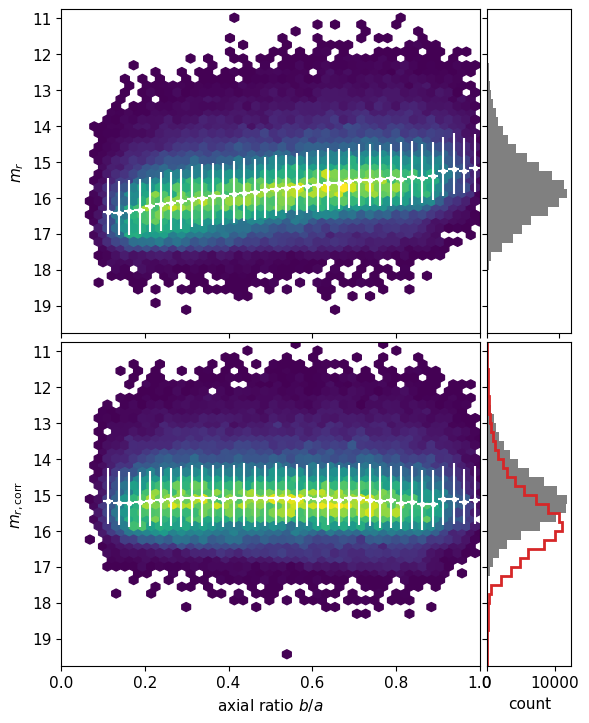

In [15]:
fig, axes = plt.subplots(2,2, figsize=(6,7.5),
                         gridspec_kw={'hspace':0.03, 'wspace':0.0295, 'width_ratios':[5,1]})

# m_r_bins = np.arange(19.75, 10.5, -0.25)
m_r_bins = np.arange(10.75, 20, 0.25)
ba_bins = np.arange(0.1, 1 + 0.025, 0.025)
ba = 0.5*(ba_bins[1:] + ba_bins[:-1])
ba_err = 0.5*np.diff(ba_bins)
m_r_median = np.median(iron['R_MAG_SB26_tmp'])
m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='median', bins=ba_bins)
n_bin, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='count', bins=ba_bins)
m_r_err, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='std', bins=ba_bins)
m_r_err_lo, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic=lambda x: np.percentile(x, [16]), bins=ba_bins)
m_r_err_hi, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic=lambda x: np.percentile(x, [84]), bins=ba_bins)
# m_r_err /= np.sqrt(n_bin)

ax = axes[0,0]
ax.hexbin(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], gridsize=(45,30), cmap='viridis', mincnt=2)
ax.errorbar(ba, m_r, xerr=ba_err, yerr=[m_r - m_r_err_lo, m_r_err_hi - m_r], fmt='.', color='white')

ax.set(xlim=(0,1),
       ylim=(19.75,10.75),
       ylabel=r'$m_r$',
       xticklabels=[])

ax = axes[0,1]
ax.hist(iron['R_MAG_SB26_tmp'], bins=m_r_bins, orientation='horizontal', color='gray')
ax.set(ylim=(19.75,10.75),
       yticklabels=[],
       xticklabels=[])

m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp']  - A_int, statistic='median', bins=ba_bins)
n_bin, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp']  - A_int, statistic='count', bins=ba_bins)
m_r_err, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp']  - A_int, statistic='std', bins=ba_bins)
m_r_err_lo, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp']  - A_int, statistic=lambda x: np.percentile(x, [16]), bins=ba_bins)
m_r_err_hi, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp']  - A_int, statistic=lambda x: np.percentile(x, [84]), bins=ba_bins)

ax = axes[1,0]
ax.hexbin(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int, gridsize=(45,30), cmap='viridis', mincnt=2)
ax.errorbar(ba, m_r, xerr=ba_err, yerr=[m_r - m_r_err_lo, m_r_err_hi - m_r], fmt='.', color='white')

ax.set(xlim=(0,1),
       ylim=(19.75,10.75),
       xlabel=r'axial ratio $b/a$',
       ylabel=r'$m_{r,\mathrm{corr}}$')

ax = axes[1,1]
ax.hist(iron['R_MAG_SB26_tmp'] - A_int, bins=m_r_bins, orientation='horizontal', color='gray')
ax.hist(iron['R_MAG_SB26_tmp'], bins=m_r_bins, orientation='horizontal', histtype='step', lw=2, color='tab:red')
ax.set(ylim=(19.75,10.75),
       yticklabels=[],
       xlabel='count')

fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.075)
# fig.savefig('TF_mock_syst_corr.png', dpi=200)

## BGS Mock Catalog

Read in one of the mock catalog files and cross-match to iron.

In [16]:
#- There are 25 BGS mocks and (usually) 27 realizations per mock.
#  Pick one, it doesn't matter which.
mockfiles = sorted(glob(os.path.join(pvpath, 'mocks/BGS_base/v0.5/iron/BGS_PV_AbacusSummit_base*.hdf5')))
n_mock = len(mockfiles)
# mockfile = mockfiles[np.random.randint(n_mock)]
mockfile = mockfiles[1]

print(f'Picked mock file {os.path.basename(mockfile)}.')

Picked mock file BGS_PV_AbacusSummit_base_c000_ph000_r001_z0.11.dat.hdf5.


In [17]:
#- Fill the catalog as a dictionary and convert to a Pandas table.
#  Here we follow the I/O from the FP generator (thanks Cullan).
mock = {}
with h5py.File(mockfile, 'r') as f:
    for key in f.keys():
        if key == 'vel':
            #- Pack the galaxy velocities into labeled vx, vy, vz
            mock['vx'] = f['vel'][:,0]
            mock['vy'] = f['vel'][:,1]
            mock['vz'] = f['vel'][:,2]
        else:
            mock[key] = f[key][()]

        # convert strings to unicode
        if key == 'survey' or key == 'program':
            mock[key] = mock[key].astype('U')

    #- Convert to a pandas table
    mock = pd.DataFrame.from_dict(mock)

    #- Merge with iron on 4 keywords
    mock = mock.merge(iron, how='inner', on=['targetid', 'survey', 'program', 'healpix'])

In [18]:
mock.keys()

Index(['Y1_COMP', 'Y3_COMP', 'Y5', 'abs_mag', 'app_mag', 'col', 'col_obs',
       'dec', 'halo_mass', 'healpix', 'is_cen', 'is_res', 'program', 'ra',
       'survey', 'targetid', 'vx', 'vy', 'vz', 'zcos', 'zobs', 'target_dec',
       'target_ra', 'z', 'zerr', 'zwarn', 'morphtype', 'sersic', 'mag_g',
       'mag_r', 'mag_z', 'uncor_radius', 'BA_ratio', 'circ_radius',
       'circ_radius_err', 'SGA_id', 'radius_SB25', 'inbasiccuts',
       'has_corrupt_phot', 'deltachi2', 'mag_err_g', 'mag_err_z', 'mag_err_r',
       'SGA_ra', 'SGA_dec', 'D26', 'G_MAG_SB26', 'G_MAG_SB26_ERR',
       'R_MAG_SB26', 'R_MAG_SB26_ERR', 'Z_MAG_SB26', 'Z_MAG_SB26_ERR',
       'photsys', 'G_MAG_SB26_tmp', 'G_MAG_SB26_ERR_tmp', 'R_MAG_SB26_tmp',
       'R_MAG_SB26_ERR_tmp', 'Z_MAG_SB26_tmp', 'Z_MAG_SB26_ERR_tmp',
       'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR'],
      dtype='object')

In [19]:
mock

Y1_COMP   Y3_COMP    Y5    abs_mag    app_mag       col   col_obs  \
0       1.000000  0.991803  True -21.603735  16.064020  0.973818  1.000261   
1       0.000000  0.962963  True -22.974319  14.690473  0.943890  0.969189   
2       1.000000  1.000000  True -20.328584  17.335948  0.754470  0.772327   
3       0.992857  0.992857  True -22.095708  15.565224  0.963012  0.988384   
4       1.000000  1.000000  True -20.940196  16.710539  0.752585  0.769231   
...          ...       ...   ...        ...        ...       ...       ...   
460957  0.845070  0.964789  True -20.442594  17.215514  1.041612  1.067414   
460958  0.993506  1.000000  True -20.977689  16.686527  0.941542  0.966701   
460959  0.609023  0.969925  True -21.044177  16.615062  0.952042  0.976926   
460960  0.958333  1.000000  True -21.492587  16.173641  1.003167  1.029903   
460961  0.886905  0.994048  True -19.926223  17.697176  0.774154  0.789158   

             dec     halo_mass  healpix  ...  Z_MAG_SB26_ERR  photsys  \
0      -0.999080  6.546589e+12    11943  ...        0.020302        N   
1       4.955850  1.250601e+14    19362  ...        0.017098        S   
2       4.141360  1.098831e+12     9063  ...        0.040119        S   
3      -2.295285  3.791707e+13     8866  ...        0.005774        S   
4      -2.161120  3.737292e+12    19996  ...        0.010283        S   
...          ...           ...      ...  ...             ...      ...   
460957  1.054418  1.092504e+12    11953  ...        0.050015        N   
460958 -5.495919  2.952714e+12    27655  ...        0.012371        S   
460959  1.892966  4.370017e+12    27655  ...        0.012371        S   
460960 -2.016671  1.960813e+13    25531  ...        0.013396        S   
460961  1.138406  8.054793e+13     8796  ...        0.035210        S   

       G_MAG_SB26_tmp  G_MAG_SB26_ERR_tmp R_MAG_SB26_tmp  R_MAG_SB26_ERR_tmp  \
0           16.836736            0.037406      15.854162            0.031360   
1           15.576678            0.038922      14.651459            0.027936   
2           17.698509            0.047886      16.911085            0.042496   
3           16.485955            0.026155      15.494399            0.018091   
4           17.428144                 NaN      16.809270                 NaN   
...               ...                 ...            ...                 ...   
460957      17.797096            0.047117      16.751333            0.048677   
460958      17.540445            0.025481      16.560813            0.019910   
460959      17.540445            0.025481      16.560813            0.019910   
460960      17.045383            0.032928      16.025221            0.024078   
460961      17.911914            0.044089      17.107244            0.039024   

        Z_MAG_SB26_tmp  Z_MAG_SB26_ERR_tmp  R_MAG_SB26_CORR  \
0            15.381491            0.030668        15.524017   
1            14.005386            0.022183        14.201208   
2            16.283822            0.041635        15.838278   
3            14.805653            0.011323        15.381549   
4            16.361631                 NaN        16.666891   
...                ...                 ...              ...   
460957       15.985596            0.054987        15.699726   
460958       15.957129            0.015125        16.226617   
460959       15.957129            0.015125        16.226617   
460960       15.330357            0.017762        15.912114   
460961       16.519934            0.036990        16.029573   

        R_MAG_SB26_ERR_CORR  
0                  0.037593  
1                  0.039746  
2                  0.079649  
3                  0.019429  
4                       NaN  
...                     ...  
460957             0.082036  
460958             0.028927  
460959             0.028927  
460960             0.025104  
460961             0.078116  

[460962 rows x 61 columns]

### Apply TF Selection Cuts

Here apply the late-type galaxy cuts defined in *Target Selection for the DESI Peculiar Velocity Survey*, C. Saulder+, MNRAS 525:1106, 2023. Note that several cuts are the complement of the early-type cuts for the FP sample.

In [20]:
mock_selection = {
    'basic cuts' : 0,
    # '0.03 < z < 0.105' : 0,
    'b/a < cos(25°)' : 0,
    'morphtype' : 0,
    'NaN' : 0
}

#- Apply target selection
print(f'Size of cross-matched iron+mock catalog ..{len(mock):.>20d}')

#- Drop data that doesn't pass the photometric cuts
select = (mock['inbasiccuts'] == 0) | (mock['has_corrupt_phot'] == 1)
mock = mock.drop(mock[select].index)
mock_selection['basic cuts'] = len(mock)
print(f'Size after photometric cuts .........{len(mock):.>20d}')

#- Redshift range cut: remove?
# select = (mock['zobs'] > 0.03) & (mock['zobs'] <= 0.105)
# mock = mock[select]
# mock_selection['0.03 < z < 0.105'] = len(mock)
# print(f'Redshift selection: 0.03 < z < 0.105 {len(mock):.>20d}')

#- B/A ratio cut:
select = mock['BA_ratio'] < np.cos(np.radians(25))
mock = mock[select]
mock_selection['b/a < cos(25°)'] = len(mock)
print(f'Ratio b/a < cos(25 deg) .............{len(mock):.>20d}')

#- Morphology cuts:
select = (mock['morphtype'] == 'EXP') | ((mock['morphtype'] == 'SER') & (mock['sersic'] <= 2))
mock = mock[select]
mock_selection['morphtype'] = len(mock)
print(f'Morphology cuts: ....................{len(mock):.>20d}')

#- Drop any rows with NaN
mock = mock.dropna()
mock_selection['NaN'] = len(mock)
print(f'Drop NaN ............................{len(mock):.>20d}')

Size of cross-matched iron+mock catalog ................460962
Size after photometric cuts .......................460765
Ratio b/a < cos(25 deg) ...........................445228
Morphology cuts: ..................................237495
Drop NaN ..........................................203127


/tmp/ipykernel_1479047/3164248107.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=45, ha='right')


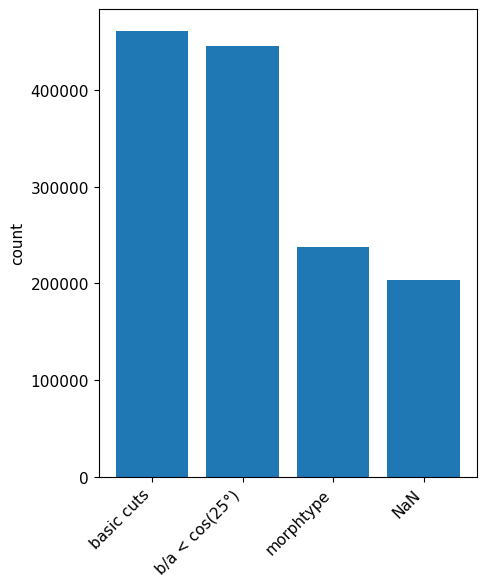

In [21]:
names = list(mock_selection.keys())
values = list(mock_selection.values())

fig, ax = plt.subplots(1, 1, figsize=(5,6), tight_layout=True)
bars = ax.bar(names, values)
ax.set_xticklabels(names, rotation=45, ha='right')
# ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4])
fig.set_facecolor('none')
# fig.savefig('tfr_mock_cuts.png', dpi=150)

## Compute TFR Quantities

Assign a rotational velocity using the data. Then use this to infer $M_r$ using the calibrated TFR.

### Set up the Cosmology

Use a flat-$\Lambda$CDM fiducial cosmology with $H_0\equiv100$ km/s/Mpc and $\Omega_m=0.3151$.

In [22]:
h = 1
cosmology = FlatLambdaCDM(H0=100*h, Om0=0.3151)

### Current Y1 TFR Best Fit

TF Y1 best-fit parameters and covariances, corresponding to v9 of the TF Y1 catalog. This comes from the TFR calibration using 7 galaxy clusters (2025-03-28) using Vmax weights to account for the galaxy size function. The TFR fit is

$$
M_r = a \log_{10}{\left(\frac{V_\mathrm{rot}}{V_0}\right)} + b_{0\mathrm{pt}}
$$

with intrinsic scatter $\sigma$ along the magnitude axis. See this [notebook](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/TF_Y1_cluster_calibration_AnthonyUpdates_weightsVmax-1_KAD.ipynb) in the [DESI_SGA/TF/Y1](https://github.com/DESI-UR/DESI_SGA/tree/master/TF/Y1) GitHub repo.

The parameter vector includes the TFR slope $a$, global zero point $b_{0\text{pt}}$, calibration cluster intercepts $\{b_i\}$, and intrinsic scatter $\sigma$.

In [66]:
with open('../cov_ab_iron_jointTFR_varyV0-dwarfsAlex_z0p1_zbins0p005_weightsVmax-1_dVsys_20251030.pickle', 'rb') as tfr_file:
    cov_ab, tfr_samples, logV0, zmin, zmax, dz, zbins = pickle.load(tfr_file)

tf_par = np.median(tfr_samples, axis=1)
a, b, sigma = tf_par[0], tf_par[1:-1], tf_par[-1]

In [96]:
# with open('cov_ab_iron_jointTFR_varyV0-perpdwarfs0_z0p1_binaryMLupdated_Anthony_weightsVmax-1_dVsys_KAD-20250523.pickle', 'rb') as tfr_file:
#     cov_ab, tfr_samples, logV0 = pickle.load(tfr_file)

# # Extract all best-fit parameters, including individual cluster intercepts.
# a, b0pt, b1, b2, b3, b4, b5, b6, b7, sigma = [np.median(tfr_samples[i]) for i in range(10)]

# # Store TF best-fit parameters.
# tf_par = np.asarray([a, b0pt, sigma])

# # Store the covariance of the intercept, slope, and intrinsic scatter.
# mask = np.zeros_like(cov_ab, dtype=bool)
# mask[:2, :2] = mask[:2, 9] = mask[9, :2] = mask[9,9] = True
# tf_cov = cov_ab[mask].reshape(3,3)

In [97]:
# with open('cov_ab_iron_jointTFR_varyV0-dwarfsAlex_z0p1_zbins0p005_weightsVmax-1_dVsys_KAD-20250810.pickle', 'rb') as tfr_file:
#     cov_ab, tfr_samples, logV0, zmin, zmax, dz, zbins = pickle.load(tfr_file)

# # Center redshift values of each bin
# zc = 0.5*dz + zbins[:-1]

# # Distance modulus for each redshift bin center
# mu_zc = cosmo.distmod(zc)

# # Each redshift bin has its own 0pt
# # To put it in absolute-magnitude space, we'll convert it to an absolute magnitude using the middle of the redshift bin
# ZP = np.median(tfr_samples[1:-1], axis=1) - mu_zc.value
# ZP_err = np.sqrt(np.diagonal(cov_ab[1:-1,1:-1])) # Should include z-bin width to this uncertainty

# # First, match each galaxy to its redshift bin
# zbin_indices = np.digitize(SGA_TF['Z_DESI_CMB'], zbins, right=True)

# # For those galaxies that fall outside the calibration range, assign them to the closest bin
# zbin_indices[zbin_indices == 0] = 1
# zbin_indices[zbin_indices == len(zbins)] = len(zbins) - 1

# # Then, use that galaxy's redshift bin's zero-point to calculate the distance modulus
# SGA_TF['R_ABSMAG_SB26_TF'] = np.nan
# for i in range(len(SGA_TF)):
#     SGA_TF['R_ABSMAG_SB26_TF'][i] = slope*(np.log10(SGA_TF['V_0p4R26'][i]) - logV0) + ZP[zbin_indices[i] - 1]

### Current TFR Catalog

Read in the TFR catalog to sample uncertainties in $V_\mathrm{rot}$.

In [35]:
tfr_version = 'v15'

tfrcatfile = os.path.join(pvpath, f'tfgalaxies/Y1/DESI-DR1_TF_pv_cat_{tfr_version}.fits')
tfrcat = Table.read(tfrcatfile)

#- Set minimum velocity uncertainty to 7 km/s.
# lowverr = tfrcat['V_0p4R26_ERR'] < 7.
# tfrcat['V_0p4R26_ERR'][lowverr] = 7.

tfrcat['logv_rot'] = np.log10(tfrcat['V_0p4R26'])
tfrcat['logv_rot_err'] = 0.434*tfrcat['V_0p4R26_ERR'] / tfrcat['V_0p4R26']

tfrcat = tfrcat['Z_DESI', 'D26', 'R_MAG_SB26', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'R_ABSMAG_SB26', 'R_ABSMAG_SB26_ERR', 'GOOD_MORPH', 'MU_ZCMB', 'MU_ZCMB_ERR', 'V_0p4R26', 'V_0p4R26_ERR', 'logv_rot', 'logv_rot_err'].to_pandas()
tfrcat

Z_DESI       D26  R_MAG_SB26  R_MAG_SB26_CORR  R_MAG_SB26_ERR_CORR  \
0      0.080990  0.417579   17.497095        16.712828             0.107923   
1      0.044002  0.495681   17.582109        16.874759             0.086265   
2      0.090040  0.567250   16.683826        15.937208             0.111025   
3      0.034026  0.575771   17.341209        16.641523             0.097170   
4      0.043319  0.953031   16.187855        15.206748             0.141361   
...         ...       ...         ...              ...                  ...   
10195  0.116921  0.369286   17.251467        16.646621             0.077811   
10196  0.054449  0.376227   17.471407        17.079648             0.044823   
10197  0.118856  0.362001   18.081808        17.636989             0.070637   
10198  0.133822  0.454465   18.177862        17.362494             0.137150   
10199  0.056664  0.569711   17.377522        16.536669             0.111050   

       R_ABSMAG_SB26  R_ABSMAG_SB26_ERR  GOOD_MORPH    MU_ZCMB  MU_ZCMB_ERR  \
0         -20.357827           0.107926        True  37.070655     0.000725   
1         -18.851691           0.086274        True  35.726451     0.001286   
2         -21.388354           0.111029        True  37.325563     0.000922   
3         -18.509705           0.097183        True  35.151228     0.001586   
4         -20.468399           0.141368        True  35.675148     0.001457   
...              ...                ...         ...        ...          ...   
10195     -21.258442           0.077813       False  37.905063     0.000546   
10196     -19.081658           0.044837        True  36.161306     0.001105   
10197     -20.308671           0.070646        True  37.945660     0.001151   
10198     -20.860460           0.137152        True  38.222953     0.000731   
10199     -19.711286           0.111056        True  36.247955     0.001136   

         V_0p4R26  V_0p4R26_ERR  logv_rot  logv_rot_err  
0      122.322388     10.869519  2.087506      0.038565  
1       81.348133      6.577976  1.910348      0.035094  
2      180.655725     13.281536  2.256852      0.031907  
3       70.102003     12.043673  1.845730      0.074562  
4      133.778523     10.944416  2.126386      0.035506  
...           ...           ...       ...           ...  
10195   95.032991     12.384687  1.977874      0.056559  
10196   44.540700     19.033877  1.648757      0.185464  
10197  123.942591     22.458671  2.093221      0.078642  
10198  172.888233     18.437635  2.237765      0.046284  
10199   78.660236     12.496419  1.895755      0.068948  

[10200 rows x 14 columns]

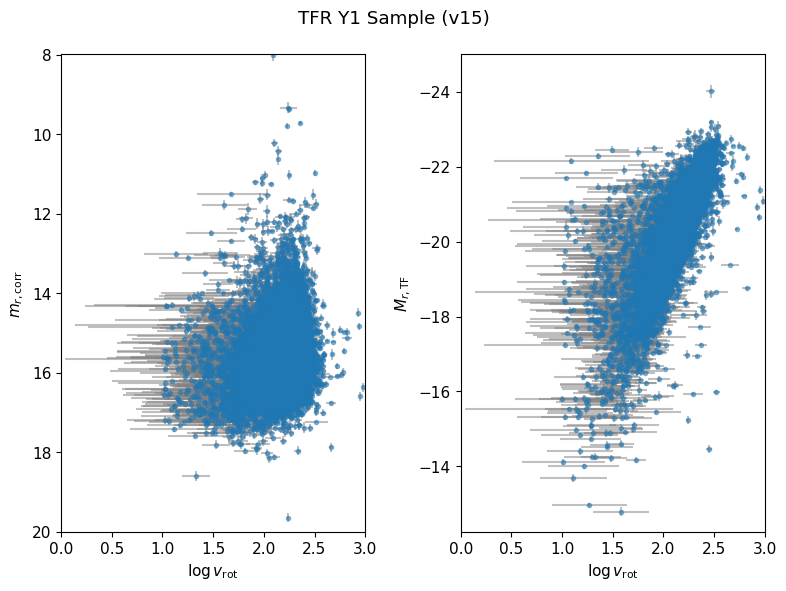

In [25]:
fig, axes = plt.subplots(1,2, figsize=(8,6), tight_layout=True, sharex=True)

ax = axes[0]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_MAG_SB26_CORR'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_MAG_SB26_ERR_CORR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$m_{r,\mathrm{corr}}$',
       ylim=(20,8))

ax = axes[1]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_ABSMAG_SB26_ERR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{TF}}$',
       ylim=(-12.25, -25))

fig.suptitle(f'TFR Y1 Sample ({tfr_version})')
fig.set_facecolor('none');
# fig.savefig('tfr_y1_sample.png', dpi=180);

### Generate Absolute Magnitudes for TFR Fitting

Procedure:
1. Calculate $M_{r,\mathrm{cos}}$ using $z_\mathrm{cos}$ from the mocks. This explicitly excludes mock peculiar velocities.
1. Compute distance moduli $\mu$ for each *observed* redshift in the mocks, $z_\mathrm{obs}$.
1. Compute $M_{r,\mathrm{obs}}$ using $m_{r,\mathrm{SB26}}$ from cross-matched from data and the generated $\mu$.
1. Scatter $\log{V_\mathrm{rot}}$ by binning the Y1 data in magnitude ($M_{r,\mathrm{cos}}$), computing the $\log{v_\mathrm{rot}}$ CDF in each bin, and randomly sampling new values.

In [36]:
#- Use distmod with cosmological redshifts to compute a "true" absolute magnitude M_r(SB26).
#  Then compute a central value for rotational velocity using this "true" magnitude.
Mr_cos = mock['R_MAG_SB26_CORR'] - cosmology.distmod(mock['zcos']).to_value('mag')

#- Compute an observed magnitude based on the PVs in the mock catalog.
mu_obs_mock = cosmology.distmod(mock['zobs']).to_value('mag')
mock['MU_OBS_MOCK'] = mu_obs_mock
Mr_obs_mock = (mock['R_MAG_SB26_CORR'] - mu_obs_mock).to_numpy()
Mr_obs_err_mock = mock['R_MAG_SB26_ERR_CORR'].to_numpy()

#- Bin R_ABSMAG_SB26. Merge any bins with < 50 datapoints, working from the ends of the magnitude range.
bins = np.arange(-26, -12 + 0.05, 0.05)
M_r_bins = [bins[0]]
for k in np.arange(1, len(bins)):
    select = (tfrcat['R_ABSMAG_SB26'] > M_r_bins[-1]) & (tfrcat['R_ABSMAG_SB26'] <= bins[k])    
    if np.sum(select) >= 50:
        M_r_bins.append(bins[k])
M_r_bins.append(bins[-1])
N_bins = len(M_r_bins)

print(np.histogram(tfrcat['R_ABSMAG_SB26'], M_r_bins))

#- Loop through the magnitude bins and regenerate log(v_rot) by resampling the data.
#  Try to reduce resampling effects by using a smoothed version of the CDF of log(v_rot).
logvrot_mock = np.zeros_like(Mr_obs_mock)

use_weighted_fit = True

for k in tqdm(np.arange(0, N_bins-1)):
    # # TEST
    # if k > 5*N_bins//9:
    #     break
    
    M_r_min, M_r_max = M_r_bins[k], M_r_bins[k+1]

    #- Select TFR velocity data in this magnitude bin and compute the CDF of log(v_rot).
    i = (tfrcat['R_ABSMAG_SB26'] > M_r_min) & (tfrcat['R_ABSMAG_SB26'] <= M_r_max)
    logvrot_slice = tfrcat['logv_rot'][i].to_numpy()
    logvrot_err_slice = tfrcat['logv_rot_err'][i].to_numpy()

    if use_weighted_fit:
        #- Attempt to build a weighted CDF
        logvrot_bins = np.arange(1, 3.01, 0.01)
        logvrot_pdf_wt, logv_bins = np.histogram(logvrot_slice, bins=logvrot_bins, 
                                                 weights=np.ones_like(logvrot_err_slice)
                                                 # weights=1/logvrot_err_slice**2
                                                )
        logvrot_cdf = np.cumsum(logvrot_pdf_wt) / np.sum(logvrot_pdf_wt)
        
        logvrot_slice = 0.5*(logvrot_bins[1:] + logvrot_bins[:-1])

        #- Keep only the unique elements in the list
        idx = np.cumsum([len(list(g)) for k, g in groupby(logvrot_cdf)])[:-1]
        logvrot_cdf = logvrot_cdf[idx]
        logvrot_slice = logvrot_slice[idx]
        # print(logvrot_cdf.shape, logvrot_slice.shape)
    else:
        #- Default to the unweighted CDF
        logvrot_cdf = np.cumsum(logvrot_slice) / np.sum(logvrot_slice)

    #- Select mock data in this magnitude bin.
    j = (Mr_cos > M_r_min) & (Mr_cos <= M_r_max)
    # j = (Mr_obs_mock > M_r_min) & (Mr_obs_mock <= M_r_max)
    N_mock_slice = np.sum(j)
    un = np.random.uniform(size=N_mock_slice)
    logvrot_mock_slice = csaps(logvrot_cdf, np.sort(logvrot_slice), un).values
    logvrot_mock[j] = logvrot_mock_slice

    #- Apply a velocity cut of 10 to 1000 km/s.
    #  Regenerate any velocities that fall outside the valid range.
    #  Note that an intermediate variable is needed to manage the array slicing.
    bad_vrot = (logvrot_mock[j] < 1) | (logvrot_mock[j] > 3)
    while np.any(bad_vrot):
        N_regen = np.sum(bad_vrot)
        uni = np.random.uniform(size=N_regen)
        logvrot_mock_regen = logvrot_mock[j]
        logvrot_mock_regen[bad_vrot] = csaps(logvrot_cdf, np.sort(logvrot_slice), uni).values
        logvrot_mock[j] = logvrot_mock_regen
        bad_vrot = (logvrot_mock[j] < 1) | (logvrot_mock[j] > 3)

# - Finally, match mock values against the Y1 data to assign uncertainties on logvrot_mock and Mr_obs_mock.
#  Many ways to do this... here just copy the FP approach of grabbing the nearest neighbor in (log v, M_r)
#  from data and taking its uncertainty.
search_tree = KDTree(np.c_[tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26']])
search_tree.query([1.5, -20])
_, idx = search_tree.query([[x, y] for (x,y) in zip(logvrot_mock, Mr_obs_mock)])

logvrot_err_mock = tfrcat['logv_rot_err'][idx].to_numpy()
Mr_obs_err_mock = mock['R_MAG_SB26_ERR_CORR'].to_numpy()

mock['LOGVROT_MOCK'] = logvrot_mock
mock['LOGVROT_ERR_MOCK'] = logvrot_err_mock
mock['R_ABSMAG_SB26_MOCK'] = Mr_obs_mock
mock['R_ABSMAG_SB26_ERR_MOCK'] = Mr_obs_err_mock

(array([ 51,  57,  77,  74,  57,  52,  63,  61,  81,  76, 107, 114, 118,
       128, 147, 161, 154, 163, 161, 167, 169, 177, 206, 156, 211, 215,
       181, 181, 197, 179, 198, 169, 168, 179, 200, 174, 163, 167, 164,
       165, 165, 146, 152, 168, 150, 141, 140, 134, 130, 129, 105, 125,
       113, 102, 127,  97, 106,  93,  87,  95,  99,  87,  87,  90,  72,
        56,  70,  71,  61,  51,  52,  54, 100,  67,  94,  87,  86,  65,
        68,  61,  68,  56,  62,  50,  53,  55,  51,  51,  53,  30]), array([-26.  , -22.55, -22.4 , -22.25, -22.15, -22.1 , -22.05, -22.  ,
       -21.95, -21.9 , -21.85, -21.8 , -21.75, -21.7 , -21.65, -21.6 ,
       -21.55, -21.5 , -21.45, -21.4 , -21.35, -21.3 , -21.25, -21.2 ,
       -21.15, -21.1 , -21.05, -21.  , -20.95, -20.9 , -20.85, -20.8 ,
       -20.75, -20.7 , -20.65, -20.6 , -20.55, -20.5 , -20.45, -20.4 ,
       -20.35, -20.3 , -20.25, -20.2 , -20.15, -20.1 , -20.05, -20.  ,
       -19.95, -19.9 , -19.85, -19.8 , -19.75, -19.7 , -19.65, -19.6 ,
 

100%|██████████| 90/90 [00:00<00:00, 224.40it/s]


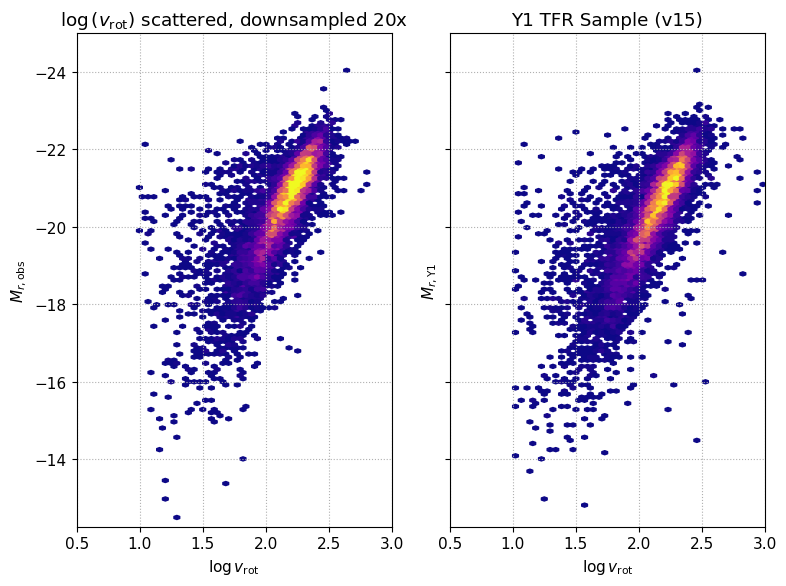

In [37]:
fig, axes = plt.subplots(1,2, figsize=(8,6), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.grid(ls=':')
ax.hexbin(mock['LOGVROT_MOCK'][::20], 
          mock['R_ABSMAG_SB26_MOCK'][::20],
          cmap='plasma', 
          mincnt=1, 
          vmin=1, 
          vmax=70, 
          gridsize=(70,80), 
          extent=(-0.1, 3.1, -25, -12.25))

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{obs}}$',
       ylim=(-12.25, -25),
       title=r'$\log{(v_\mathrm{rot})}$ scattered, downsampled 20x')

ax = axes[1]
ax.grid(ls=':')
ax.hexbin(tfrcat['logv_rot'], 
          tfrcat['R_ABSMAG_SB26'],
          cmap='plasma', 
          mincnt=1, 
          vmin=1, 
          vmax=70, 
          gridsize=(70,80), 
          extent=(-0.1, 3.1, -25, -12.25))

ax.set(xlim=(0.5,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{Y1}}$',
       ylim=(-12.25, -25),
       title=f'Y1 TFR Sample ({tfr_version})');

In [101]:
# k = 2*N_bins//3
# M_r_min, M_r_max = M_r_bins[k], M_r_bins[k+1]

# #- Select TFR velocity data in this magnitude bin and compute the CDF of log(v_rot).
# i = (tfrcat['R_ABSMAG_SB26'] > M_r_min) & (tfrcat['R_ABSMAG_SB26'] <= M_r_max)
# logvrot_slice = tfrcat['logv_rot'][i].to_numpy()
# logvrot_err_slice = tfrcat['logv_rot_err'][i].to_numpy()
# logvrot_cdf = np.cumsum(logvrot_slice) / np.sum(logvrot_slice)

# fig, axes = plt.subplots(1, 4, figsize=(16,4), tight_layout=True)

# logvrot_bins = np.arange(1, 3.05, 0.05)

# ax = axes[0]
# ax.hist(logvrot_slice, bins=logvrot_bins)
# ax.set(xlabel=r'$\log{v_\mathrm{rot}}$',
#        ylabel=r'count',
#        title='slice histogram')

# ax = axes[1]
# logvrot_pdf_wt, logv_bins, _ = ax.hist(logvrot_slice, bins=logvrot_bins, weights=1/logvrot_err_slice**2)
# newcdf_wt = np.cumsum(logvrot_pdf_wt) / np.sum(logvrot_pdf_wt)
# ax.set(xlabel=r'$\log{v_\mathrm{rot}}$',
#        title='weighted slice histogram')

# ax = axes[2]
# logvrot_gen = np.random.multivariate_normal(mean=logvrot_slice, cov=np.diag(logvrot_err_slice**2), size=1000).flatten()
# logvrot_pdf_rsmpl, logv_bins, _ = ax.hist(logvrot_gen, bins=logvrot_bins)
# newcdf_rsmpl = np.cumsum(logvrot_pdf_rsmpl) / np.sum(logvrot_pdf_rsmpl)
# ax.set(xlabel=r'$\log{v_\mathrm{rot}}$',
#        title='resampled histogram')

# ax = axes[3]
# ax.plot(np.sort(logvrot_slice), logvrot_cdf, label='unweighted CDF')
# ax.plot(logv_bins[:-1], newcdf_wt, label='weighted CDF')
# ax.plot(logv_bins[:-1], newcdf_rsmpl, label='resampled CDF')
# ax.set(xlabel=r'$\log{v_\mathrm{rot}}$',
#        title='CDF')
# l = ax.legend(loc='upper left', fontsize=10)

#### Apply Alex's Velocity and Dwarf Cuts

Alex's cuts, defined August 2025, are:
* $m_r < \min{(17.75, \mu_\mathrm{CMB} - 17 + 5\log{h})}$, a cut on dwarfs
* $70~\mathrm{km/s} < V_\mathrm{rot}(0.4R_{26}) < 300~\mathrm{km/s}$, a vertical velocity cut
* $V_\mathrm{rot}(0.4R_{26}) < \min{(300~\mathrm{km/s}, 10^{0.3(\mu_\mathrm{CMB} - 34 + 5\log{h}) + 2})}$, a distance-dependent velocity cut

In [38]:
def downsample(mock, size=100):
    """Randomly downsample a mock catalog, without replacement, to some size.

    Parameters
    ----------
    mock: pandas.DataFrame
        Pandas table with a mock catalog.
    size: int
        Size of the final downsampled catalog.

    Returns
    -------
    newmock: pandas.DataFrame
        Downsampled Pandas table.
    """
    Nmock = len(mock)
    idx_downsample = np.random.choice(Nmock, size, replace=False)
    return mock.iloc[idx_downsample]

def alex_cuts_velocity(catalog, logv_name='logv_rot', distmod_name='MU_ZCMB', vmin=70., vmax=300., h=1.):
    """Apply Alex's velocity cuts (Aug. 2025).

    Parameters
    ----------
    catalog: pandas.DataFrame
        Pandas table with a catalog (data or mock).
    logv_name: str
        Name of the rotational velocity column in the table.
    distmod_name: str
        Name of the distance modulus column in the table.
    vmin: float
        Minimum velocity cut in km/s.
    vmax: float
        Maximum velocity cut in km/s.
    h: float
        Dimensionless Hubble constant.

    Returns
    -------
    select: list or np.array
        Indices of table elements passing the cuts.
    """
    logVmin, logVmax = np.log10(vmin), np.log10(vmax)
    a = 0.3
    b = 34 + 5*np.log10(h)
    mu_obs = catalog[distmod_name]
    logVMmax = np.minimum(logVmax, a*(mu_obs - b) + 2)
    select = (catalog[logv_name] > logVmin) & (catalog[logv_name] < logVmax) & (catalog[logv_name] < logVMmax)
    return select

def alex_cuts_dwarf(catalog, rmag_name='R_MAG_SB26', distmod_name='MU_ZCMB', h=1.):
    """Apply Alex's dwarf galaxy cuts (Aug. 2025).

    Parameters
    ----------
    catalog: pandas.DataFrame
        Pandas table with a catalog (data or mock).
    rmag_name: str
        Name of the r-band magnitude used for computing the cut.
    distmod_name: str
        Name of the distance modulus column in the table.
    h: float
        Dimensionless Hubble constant.

    Returns
    -------
    select: list or np.array
        Indices of table elements that are *not* classified as dwarfs.
    """
    Rlim = 17.75
    Mlim = -17 + 5*np.log10(h)
    Rlim_eff = np.minimum(Rlim, catalog[distmod_name] + Mlim)
    select = catalog[rmag_name] <= Rlim_eff
    return select

#### Plot $M_{R,\mathrm{SB26}}$ for Mocks and TFR Data

Make a side-by-side comparison of the (downsampled) mock catalog and Y1 data.

Apply the quality cuts equally to both.

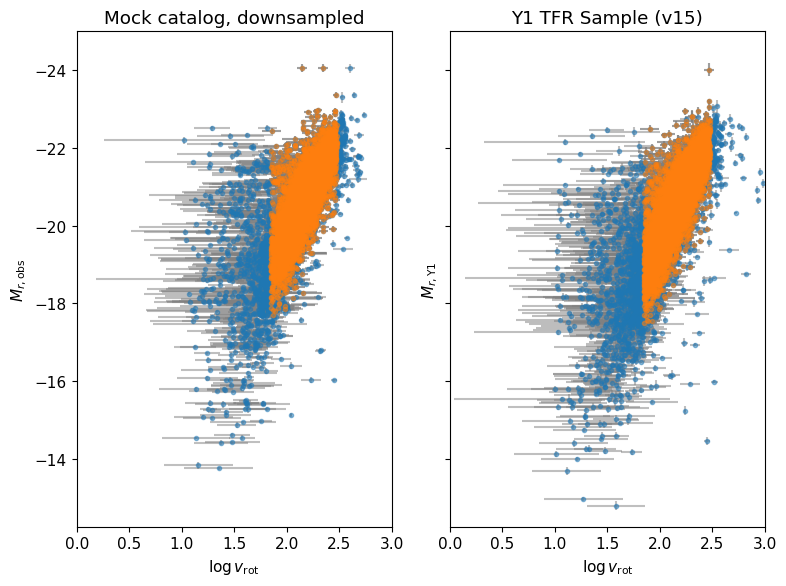

In [39]:
#- Plot Mr vs log(v_rot) for the various steps in the calculation.

fig, axes = plt.subplots(1,2, figsize=(8,6), tight_layout=True, sharex=True, sharey=True)

Ntfr = len(tfrcat)
mock_downsample = downsample(mock, Ntfr)

ax = axes[0]
ax.errorbar(mock_downsample['LOGVROT_MOCK'], mock_downsample['R_ABSMAG_SB26_MOCK'],
            xerr=mock_downsample['LOGVROT_ERR_MOCK'],
            yerr=mock_downsample['R_ABSMAG_SB26_ERR_MOCK'],
            fmt='.', 
            alpha=0.5, 
            ecolor='gray')

idx_mock_goodv = alex_cuts_velocity(mock_downsample, logv_name='LOGVROT_MOCK', distmod_name='MU_OBS_MOCK')
# idx_mock_notdwarf = alex_cuts_dwarf(mock_downsample, rmag_name='R_MAG_SB26_CORR', distmod_name='MU_OBS_MOCK')
idx_mock_notdwarf = alex_cuts_dwarf(mock_downsample, rmag_name='R_MAG_SB26', distmod_name='MU_OBS_MOCK')
idx_mock_good = idx_mock_goodv & idx_mock_notdwarf

ax.errorbar(mock_downsample['LOGVROT_MOCK'][idx_mock_good], mock_downsample['R_ABSMAG_SB26_MOCK'][idx_mock_good],
             xerr=mock_downsample['LOGVROT_ERR_MOCK'][idx_mock_good],
             yerr=mock_downsample['R_ABSMAG_SB26_ERR_MOCK'][idx_mock_good],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{obs}}$',
       ylim=(-12.25, -25),
       title=r'Mock catalog, downsampled')

ax = axes[1]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_ABSMAG_SB26_ERR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

idx_tfr_goodv = alex_cuts_velocity(tfrcat, logv_name='logv_rot', distmod_name='MU_ZCMB')
# idx_tfr_notdwarf = alex_cuts_dwarf(tfrcat, rmag_name='R_MAG_SB26_CORR', distmod_name='MU_ZCMB')
idx_tfr_notdwarf = alex_cuts_dwarf(tfrcat, rmag_name='R_MAG_SB26', distmod_name='MU_ZCMB')
idx_tfr_good = idx_tfr_goodv & idx_tfr_notdwarf

ax.errorbar(tfrcat['logv_rot'][idx_tfr_good], tfrcat['R_ABSMAG_SB26'][idx_tfr_good],
             xerr=tfrcat['logv_rot_err'][idx_tfr_good],
             yerr=tfrcat['R_ABSMAG_SB26_ERR'][idx_tfr_good],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{Y1}}$',
       ylim=(-12.25, -25),
       title=f'Y1 TFR Sample ({tfr_version})');

fig.set_facecolor('none');
# fig.savefig('tfr_mock_mr_vs_logv.png', dpi=150);

In [40]:
mpl.rc('font', size=12)

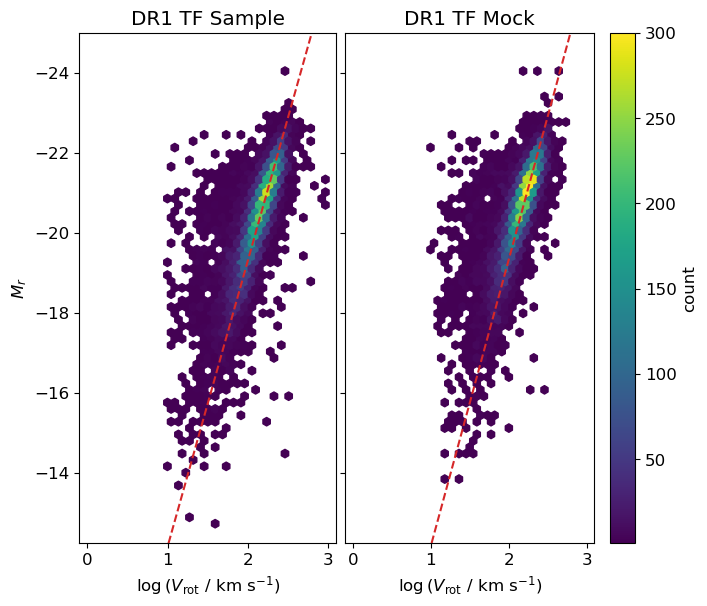

In [41]:
fig, axes = plt.subplots(1,2, figsize=(7,6), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0.03, 'width_ratios':[0.825,1]})

ax = axes[0]
ax.hexbin(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'],
          cmap='viridis', mincnt=1, 
          vmin=1, vmax=3e2,
          gridsize=(35,40), extent=(-0.1, 3.1, -25, -12.25))
ax.set(xlim=(-0.1,3.1),
       xlabel=r'$\log{(V_\mathrm{rot}~/~\mathrm{km~s}^{-1})}$',
       ylabel=r'$M_{r}$',
       ylim=(-12.25, -25),
       title=f'DR1 TF Sample')# ({tfr_version})');

_log_v_rot = np.arange(-0.1, 3.05, 0.05)
b0 = -5
a0 = -7.16
ax.plot(_log_v_rot, b0 + a0*_log_v_rot, ls='--', color='tab:red')

ax = axes[1]
h = ax.hexbin(mock_downsample['LOGVROT_MOCK'], mock_downsample['R_ABSMAG_SB26_MOCK'],
              cmap='viridis', mincnt=1, 
              vmin=1, vmax=3e2,
              gridsize=(35,40), extent=(-0.1, 3.1, -25, -12.25))
cb = fig.colorbar(h, ax=ax, label='count')

ax.set(xlim=(-0.1,3.1),
       xlabel=r'$\log{(V_\mathrm{rot}~/~\mathrm{km~s}^{-1})}$',
       # ylabel=r'$M_{r,\mathrm{Y1}}$',
       ylim=(-12.25, -25),
       title=f'DR1 TF Mock')

_log_v_rot = np.arange(-0.1, 3.05, 0.05)
b0 = -5
a0 = -7.16
ax.plot(_log_v_rot, b0 + a0*_log_v_rot, ls='--', color='tab:red')

fig.subplots_adjust(left=0.1, right=0.925, top=0.95, bottom=0.1)
fig.savefig('TF_mock_dr1_relation.png', dpi=200)

mpl.rc('font', size=11);

#### Apply Quality Cuts to the Full Mock Sample

In [42]:
idx_mock_goodv = alex_cuts_velocity(mock, logv_name='LOGVROT_MOCK', distmod_name='MU_OBS_MOCK')
# idx_mock_notdwarf = alex_cuts_dwarf(mock, rmag_name='R_MAG_SB26_CORR', distmod_name='MU_OBS_MOCK')
idx_mock_notdwarf = alex_cuts_dwarf(mock, rmag_name='R_MAG_SB26', distmod_name='MU_OBS_MOCK')
idx_mock_good = idx_mock_goodv & idx_mock_notdwarf

print(sum(idx_mock_notdwarf), sum(idx_mock_goodv))
print(np.sum(idx_mock_good), len(mock))

194024 165769
163105 203127


### Compute the Maximum Volume for each Galaxy

Since the SGA is size-limited, with $D_{26}>0.2'$, there is a maximum volume within which the galaxy could be located to be included in the SGA. Calculate the maximum volume to be used as a weight in the TFR calibration.

In [43]:
dist = cosmology.luminosity_distance(np.abs(mock['zobs']))
dist_max = cosmology.luminosity_distance(z=0.1)
d26_kpc = 2*dist.to('kpc') * np.tan(0.5*mock['D26'].values*u.arcmin)
mock_dist_max = 0.5*d26_kpc / np.tan(0.1*u.arcmin)
# surv_max = cosmology.luminosity_distance(z=0.2)

# mock['D26_kpc'] = 2*dist.to_value('kpc') * np.tan(0.5*mock['D26'].values*u.arcmin)
# mock['DIST_MAX'] = 0.5*mock['D26_kpc'].values / np.tan(0.1*u.arcmin)
# mock['MAX_VOL_FRAC'] = (1e-3 * mock['DIST_MAX'].values)**3 / dist_max.to_value('Mpc')**3
mock['MAX_VOL_FRAC'] = mock_dist_max.to('Mpc')**3 / dist_max.to('Mpc')**3

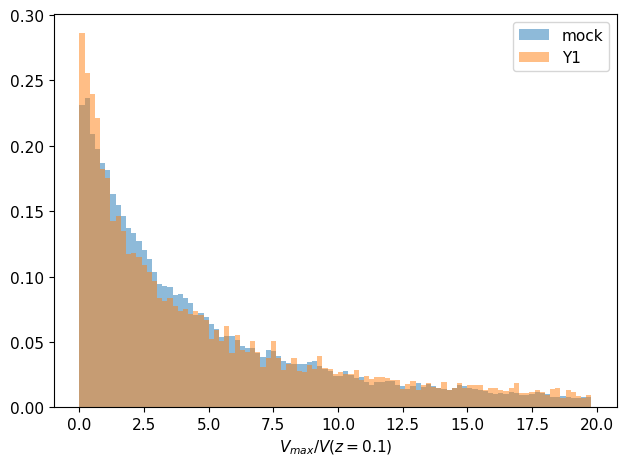

In [44]:
plt.figure(tight_layout=True)

iron_dist = cosmology.luminosity_distance(np.abs(tfrcat['Z_DESI'].values))
iron_d26kpc = 2*iron_dist.to('kpc') * np.tan(0.5*tfrcat['D26'].values*u.arcmin)
iron_dist_max = 0.5*iron_d26kpc / np.tan(0.1*u.arcmin)

plt.hist(mock['MAX_VOL_FRAC'], np.arange(0, 20, 0.2), density=True, alpha=0.5, label='mock')
plt.hist(iron_dist_max.to('Mpc')**3 / dist_max.to('Mpc')**3, np.arange(0, 20, 0.2), density=True, alpha=0.5, label='Y1')

plt.legend()

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

### Fit the TFR and Compute Mock Distance Moduli

Fit $M_{r,\mathrm{obs,mock}}$ versus $\log{V_\mathrm{rot,mock}}$ to get a mock TFR.

Then compute the TF distance modulus as

$$
\mu_\mathrm{mock} = m_{r,\mathrm{SB_{26}}} - M_{r,\mathrm{obs,mock}},
$$

where the apparent magnitude is the quantity `R_MAG_SB26_CORR` used to compute magnitudes from the cosmological and observed redshift.

#### Create a Synthetic Data Set for TFR Fitting

In [48]:
# Ntfr_cal = 4918 # Number of galaxies that make it through all the calibration cuts
mock_downsample = downsample(mock[idx_mock_good], Ntfr)

idx_mock_downsample_goodv = alex_cuts_velocity(mock_downsample, logv_name='LOGVROT_MOCK', distmod_name='MU_OBS_MOCK')
# idx_mock_downsample_notdwarf = alex_cuts_dwarf(mock_downsample, rmag_name='R_MAG_SB26_CORR', distmod_name='MU_OBS_MOCK')
idx_mock_downsample_notdwarf = alex_cuts_dwarf(mock_downsample, rmag_name='R_MAG_SB26', distmod_name='MU_OBS_MOCK')
idx_mock_downsample_good = idx_mock_downsample_goodv & idx_mock_downsample_notdwarf

print(f'Nmock      = {len(mock_downsample):6d}\n'
      f'Nmock_cuts = {len(mock_downsample[idx_mock_downsample_good]):6d}\n'
      f'Ntfr       = {len(tfrcat):6d}\n'
      f'Ntfr_cuts  = {len(tfrcat[idx_tfr_good]):6d}')

Nmock      =  10200
Nmock_cuts =  10200
Ntfr       =  10200
Ntfr_cuts  =   8048


In [49]:
zbin_idx = np.digitize(mock_downsample['zobs'], zbins, right=True)
for i in range(len(zbins) + 1):
    if i == 0:
        print(f'{i:2d}  z <= {zbins[i]:0.3f}  {np.sum(zbin_idx == i):3d} galaxies')
    elif i == len(zbins):
        print(f'{i:2d}  z > {zbins[i-1]:0.3f}  {np.sum(zbin_idx == i):3d} galaxies')
    else:
        print(f'{i:2d}  {zbins[i-1]:0.3f} < z <= {zbins[i]:0.3f}  {np.sum(zbin_idx == i):3d} galaxies')

 0  z <= 0.030  788 galaxies
 1  0.030 < z <= 0.035  809 galaxies
 2  0.035 < z <= 0.040  916 galaxies
 3  0.040 < z <= 0.045  879 galaxies
 4  0.045 < z <= 0.050  868 galaxies
 5  0.050 < z <= 0.055  792 galaxies
 6  0.055 < z <= 0.060  747 galaxies
 7  0.060 < z <= 0.065  744 galaxies
 8  0.065 < z <= 0.070  666 galaxies
 9  0.070 < z <= 0.075  667 galaxies
10  0.075 < z <= 0.080  575 galaxies
11  0.080 < z <= 0.085  435 galaxies
12  0.085 < z <= 0.090  396 galaxies
13  0.090 < z <= 0.095  273 galaxies
14  0.095 < z <= 0.100  253 galaxies
15  z > 0.100  392 galaxies


In [50]:
# Downsample the mock catalog after cuts to 4200 galaxies.

no_use = (zbin_idx == 0) | (zbin_idx == len(zbins))
mock_downsample = downsample(mock_downsample[idx_mock_downsample_good & ~no_use], size=4200)

zbin_idx = np.digitize(mock_downsample['zobs'], zbins, right=True)
for i in range(len(zbins) + 1):
    if i == 0:
        print(f'{i:2d}  z <= {zbins[i]:0.3f}  {np.sum(zbin_idx == i):3d} galaxies')
    elif i == len(zbins):
        print(f'{i:2d}  z > {zbins[i-1]:0.3f}  {np.sum(zbin_idx == i):3d} galaxies')
    else:
        print(f'{i:2d}  {zbins[i-1]:0.3f} < z <= {zbins[i]:0.3f}  {np.sum(zbin_idx == i):3d} galaxies')

 0  z <= 0.030    0 galaxies
 1  0.030 < z <= 0.035  377 galaxies
 2  0.035 < z <= 0.040  427 galaxies
 3  0.040 < z <= 0.045  400 galaxies
 4  0.045 < z <= 0.050  387 galaxies
 5  0.050 < z <= 0.055  371 galaxies
 6  0.055 < z <= 0.060  371 galaxies
 7  0.060 < z <= 0.065  359 galaxies
 8  0.065 < z <= 0.070  312 galaxies
 9  0.070 < z <= 0.075  311 galaxies
10  0.075 < z <= 0.080  254 galaxies
11  0.080 < z <= 0.085  191 galaxies
12  0.085 < z <= 0.090  181 galaxies
13  0.090 < z <= 0.095  131 galaxies
14  0.095 < z <= 0.100  128 galaxies
15  z > 0.100    0 galaxies


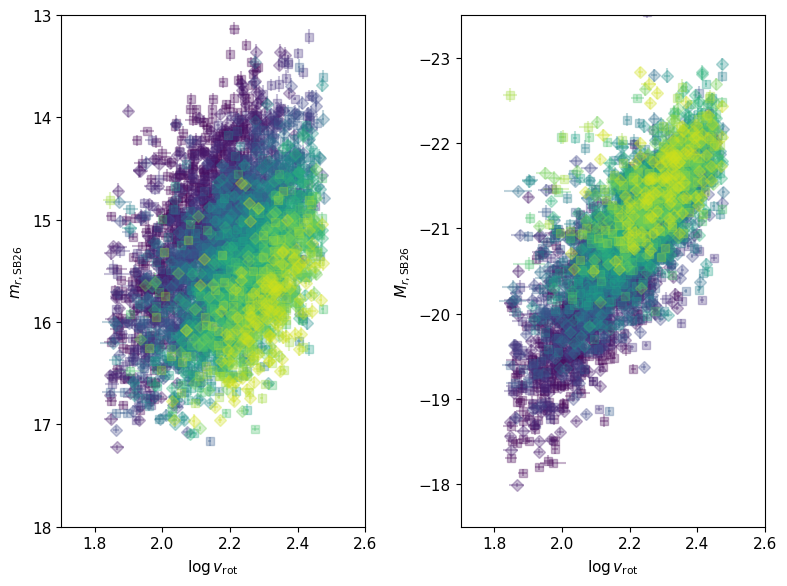

In [67]:
fig, axes = plt.subplots(1,2, figsize=(8,6), sharex=True, tight_layout=True)

_zbin_ids = np.sort(np.unique(zbin_idx))
n_zbins = len(_zbin_ids)

markers = 'sDv^<>'

colors = iter(plt.cm.viridis(np.linspace(0,1, n_zbins + 1)))

for j, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(zbin_idx, _zbin_id)

    logv = mock_downsample['LOGVROT_MOCK'][select_zbin]
    logv_err = 0.434*mock_downsample['LOGVROT_ERR_MOCK'][select_zbin] / mock_downsample['LOGVROT_MOCK'][select_zbin]

    mr26 = mock_downsample['R_MAG_SB26_CORR'][select_zbin]
    mr26_err = mock_downsample['R_MAG_SB26_ERR_CORR'][select_zbin]

    Mr26 = mock_downsample['R_ABSMAG_SB26_MOCK'][select_zbin]
    Mr26_err = mock_downsample['R_ABSMAG_SB26_ERR_MOCK'][select_zbin]

    c = next(colors)

    ax = axes[0]
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err,
                fmt=markers[j % 2], markersize=6, alpha=0.3,
                color=c)

    ax = axes[1]
    ax.errorbar(x=logv, y=Mr26, xerr=logv_err, yerr=Mr26_err,
                fmt=markers[j % 2], markersize=6, alpha=0.3,
                color=c)

ax = axes[0]
ax.set(xlim=(1.7, 2.6),
       ylim=(18, 13),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$m_{r,\mathrm{SB26}}$')

ax = axes[1]
ax.set(ylim=(-17.5, -23.5),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{SB26}}$');

#### Pack the Data and Fit with `MultiLinFit`

In [69]:
bounds = [[-20, 0]]              # Bounds on a (slope)
bounds += n_zbins*[(0, 20)]    # Bounds on b (intercepts: z-bins)
bounds += [(0,2)]#5)]                # Bounds on sigma

# logV0_mock = np.median(mock_downsample['LOGVROT_MOCK'])
# print(logV0_mock)

datasets = [] # list of (2xN) arrays of the data
covs = []     # covariance of zero point and slope for each "cluster"

for j, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(zbin_idx, _zbin_id)

    logv = mock_downsample['LOGVROT_MOCK'].to_numpy()[select_zbin] - logV0#_mock
    dlogv = mock_downsample['LOGVROT_ERR_MOCK'].to_numpy()[select_zbin]
    mr = mock_downsample['R_MAG_SB26_CORR'].to_numpy()[select_zbin]
    dmr = mock_downsample['R_MAG_SB26_ERR_CORR'].to_numpy()[select_zbin]

    N = len(logv)
    cov = np.empty((2, 2, N))
    for i in range(N):
        cov[:,:,i] = np.array([[dlogv[i]**2, 0.], [0., dmr[i]**2]])
    covs.append(cov)

    data = np.empty((2, N))
    data[0] = logv
    data[1] = mr
    datasets.append(data)

hf = MultiLinFit(datasets, covs, scatter=1)
pars, parscatter, lnpost = hf.optimize(bounds)

In [70]:
pars, parscatter

(array([-7.58428501, 14.21388909, 14.62316826, 14.85829749, 15.23219642,
        15.3894664 , 15.58251591, 15.84049901, 15.99069103, 16.1717593 ,
        16.29980918, 16.48402953, 16.55876598, 16.61777814, 16.84803921]),
 array([0.5265701]))

#### Try the Fit using MCMC

In [71]:
# Determine logV0 for the test calibration
# logV0_mock = np.median(logvrot_mock[idx])
# logV0_mock = np.median(mock_downsample['LOGVROT_MOCK'])
# print(logV0_mock)

# Pack the calibration set into lists
logv, dlogv = [], []
mr, dmr = [], []
weights = []

# Loop over redshift bins
for j, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(zbin_idx, _zbin_id)

    logv.append(mock_downsample['LOGVROT_MOCK'].to_numpy()[select_zbin] - logV0)#_mock)
    dlogv.append(mock_downsample['LOGVROT_ERR_MOCK'].to_numpy()[select_zbin])
    mr.append(mock_downsample['R_MAG_SB26_CORR'].to_numpy()[select_zbin])
    dmr.append(mock_downsample['R_MAG_SB26_ERR_CORR'].to_numpy()[select_zbin])
    weights.append(np.ones_like(mock_downsample['LOGVROT_MOCK'][select_zbin]))

In [72]:
# Number of redshift bins
bounds = [[-20, 0]]        # Bounds on a (slope)
bounds += n_zbins*[(0, 20)]    # Bounds on b (intercepts: z-bins)
bounds += [(0,2)]#5)]          # Bounds on sigma

# logging.warning('Fit does not account for volume weights.')

results = hyperfit_line_multi(logv, mr, dlogv, dmr, bounds, weights=weights, scatter=1)

a_mcmc, b_mcmc, sigma_mcmc, cov_mcmc, mcmc_samples, hf = results

     fun: -2826351.9545527576
     jac: array([  4.74974516,  -5.21540599,  47.68371187,   9.96515072,
        -3.44589324,   3.16649649,   3.35276099,  -8.38190248,
        -8.10250573,   5.30853824,  -7.91624123,  -0.09313225,
         1.72294662,   2.32830624, -16.95006946, -14.80802886])
 message: 'Optimization terminated successfully.'
    nfev: 37901
     nit: 156
 success: True
       x: array([-7.58443285, 14.21386101, 14.6231615 , 14.85825393, 15.23218956,
       15.38941036, 15.58247301, 15.84045412, 15.99090739, 16.17170327,
       16.29986849, 16.48447111, 16.55913882, 16.61864894, 16.84810202,
        0.52641904])
Ndim: 16 14


100%|██████████| 1000/1000 [00:46<00:00, 21.63it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [69.76420137 53.0580578  40.02911357 50.8141464  43.61615006 50.3794681
 53.19077769 49.88454114 50.8656911  48.10389889 48.43722503 66.94293043
 58.03884064 71.78343536 90.65562372 58.8018035 ] / 4532.781185803556


100%|██████████| 1000/1000 [00:46<00:00, 21.71it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [92.48695384 63.29325924 49.00318379 54.69154354 55.85725091 47.7660979
 56.58373314 57.03727746 67.31116544 52.92681696 58.41933735 79.05452961
 66.52205953 70.28379812 93.84548482 92.97749931] / 4692.274240864359


100%|██████████| 1000/1000 [00:46<00:00, 21.60it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 96.77140113  51.8797215   45.97510903  53.18755749  54.64393901
  54.86695396  62.12615592  55.36851063  60.01804129  60.89873893
  66.42050046  75.82517137  68.06846225  76.41973707 104.23767492
 108.0704123 ] / 5403.520614982375


100%|██████████| 1000/1000 [00:46<00:00, 21.46it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [110.40042774  64.18181575  55.46976949  55.35866694  59.17066319
  66.44349689  67.96148793  62.14128719  63.35075468  70.92822297
  76.70595914  84.06776631  99.78318046  83.16249424  88.35381421
 142.59654164] / 7129.82708208527


100%|██████████| 1000/1000 [00:45<00:00, 21.79it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [117.07934716  63.41896754  53.67032276  55.38113611  53.66605226
  66.11158618  65.37663378  76.38776563  59.85492628  62.99055519
  77.32502405  95.7778122   98.76310875  92.27938654  90.62344115
 152.94240186] / 7647.120093152163


100%|██████████| 1000/1000 [00:45<00:00, 21.83it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [125.73432088  71.80249316  55.72336754  55.73720921  56.61520719
  60.82445234  67.12243649  71.86428761  77.57846698  67.17937851
  75.28581292  82.95657041  97.78319696 104.72204442  90.49014951
 133.59509245] / 6679.754622652375


100%|██████████| 1000/1000 [00:45<00:00, 21.77it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [132.07996422  68.07412769  56.58817728  57.77427622  57.7794488
  55.59207955  63.73617055  70.88193065  73.35058804  69.49402061
  80.20504972  78.78457587  97.26975488 103.8620666   96.27034975
 133.05498188] / 6652.749093782018


100%|██████████| 1000/1000 [00:45<00:00, 21.89it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [147.02418009  64.69186762  56.20339128  57.41166749  56.0598445
  53.99403562  69.58300345  74.39947363  78.55679319  70.55417626
  79.96258443  82.57691022  92.74453881 105.75503192  93.75829212
 136.17332058] / 7351.209004478561


100%|██████████| 1000/1000 [00:45<00:00, 21.86it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [140.60863553  68.77484348  56.5402557   56.42970491  56.36781413
  53.58830224  70.02347055  75.50594299  77.72695326  64.68428876
  78.5025382   87.25262042 134.27398117 106.74550814  97.62952612
 141.07973688] / 7053.986843966587


100%|██████████| 1000/1000 [00:45<00:00, 21.82it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [143.69944581  73.6562153   56.58267112  56.96683826  60.38097007
  58.64165583  72.91664569  70.45893887  78.50653572  71.68785619
  74.76961294  88.81120022 136.79797671 104.13966968  97.99607765
 151.91901604] / 7595.950801917712


100%|██████████| 1000/1000 [00:46<00:00, 21.40it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [149.29622846  74.0317525   54.89913156  57.97612341  59.154369
  58.15327575  70.28353269  73.52035208  77.78543301  69.3916126
  76.52196746  87.15375279 130.07998364  99.87038683 101.199425
 167.57355185] / 8378.677592502429


100%|██████████| 1000/1000 [00:46<00:00, 21.69it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [140.7663613   73.57476511  54.82934163  61.78144321  60.25549193
  55.44786162  68.33725199  76.24747916  74.48004609  71.57829405
  78.06459077  89.92014482 115.3489301  100.88480966  96.90013534
 163.17791444] / 8158.895721861812


100%|██████████| 1000/1000 [00:47<00:00, 21.04it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [141.77508189  69.59296454  55.5234646   59.21056047  59.65121685
  55.14811414  64.99626269  74.46209509  71.94557504  70.57667399
  76.3770602   87.09481282 112.98636967  98.94411029  95.22043922
 167.74908846] / 8387.454422944986


100%|██████████| 1000/1000 [00:46<00:00, 21.62it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [149.42868572  72.31307348  60.21987398  68.34395367  61.88072201
  57.39127955  66.57415921  84.51970959  75.55832415  69.72784428
  76.47996349  90.79583209 115.56775984 100.33323837  94.0593975
 168.16084663] / 8408.042331690647


100%|██████████| 1000/1000 [00:46<00:00, 21.65it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [145.14440621  70.22058938  58.57954767  68.73937976  62.02707272
  56.99856648  66.11996878  81.7955517   76.14105516  68.97433067
  74.39762438  94.98726936 112.38461474 101.26753515  98.23623633
 173.56859544] / 8678.429771755993


#### Plot the HyperFit Results

In [73]:
values = np.median(mcmc_samples, axis=1)
sigmas = np.sqrt(np.diag(cov_mcmc))

multiple = 3.5

limits = []

for i in range(len(values)):
    limits.append([values[i] - multiple*sigmas[i], 
                   values[i] + multiple*sigmas[i]])

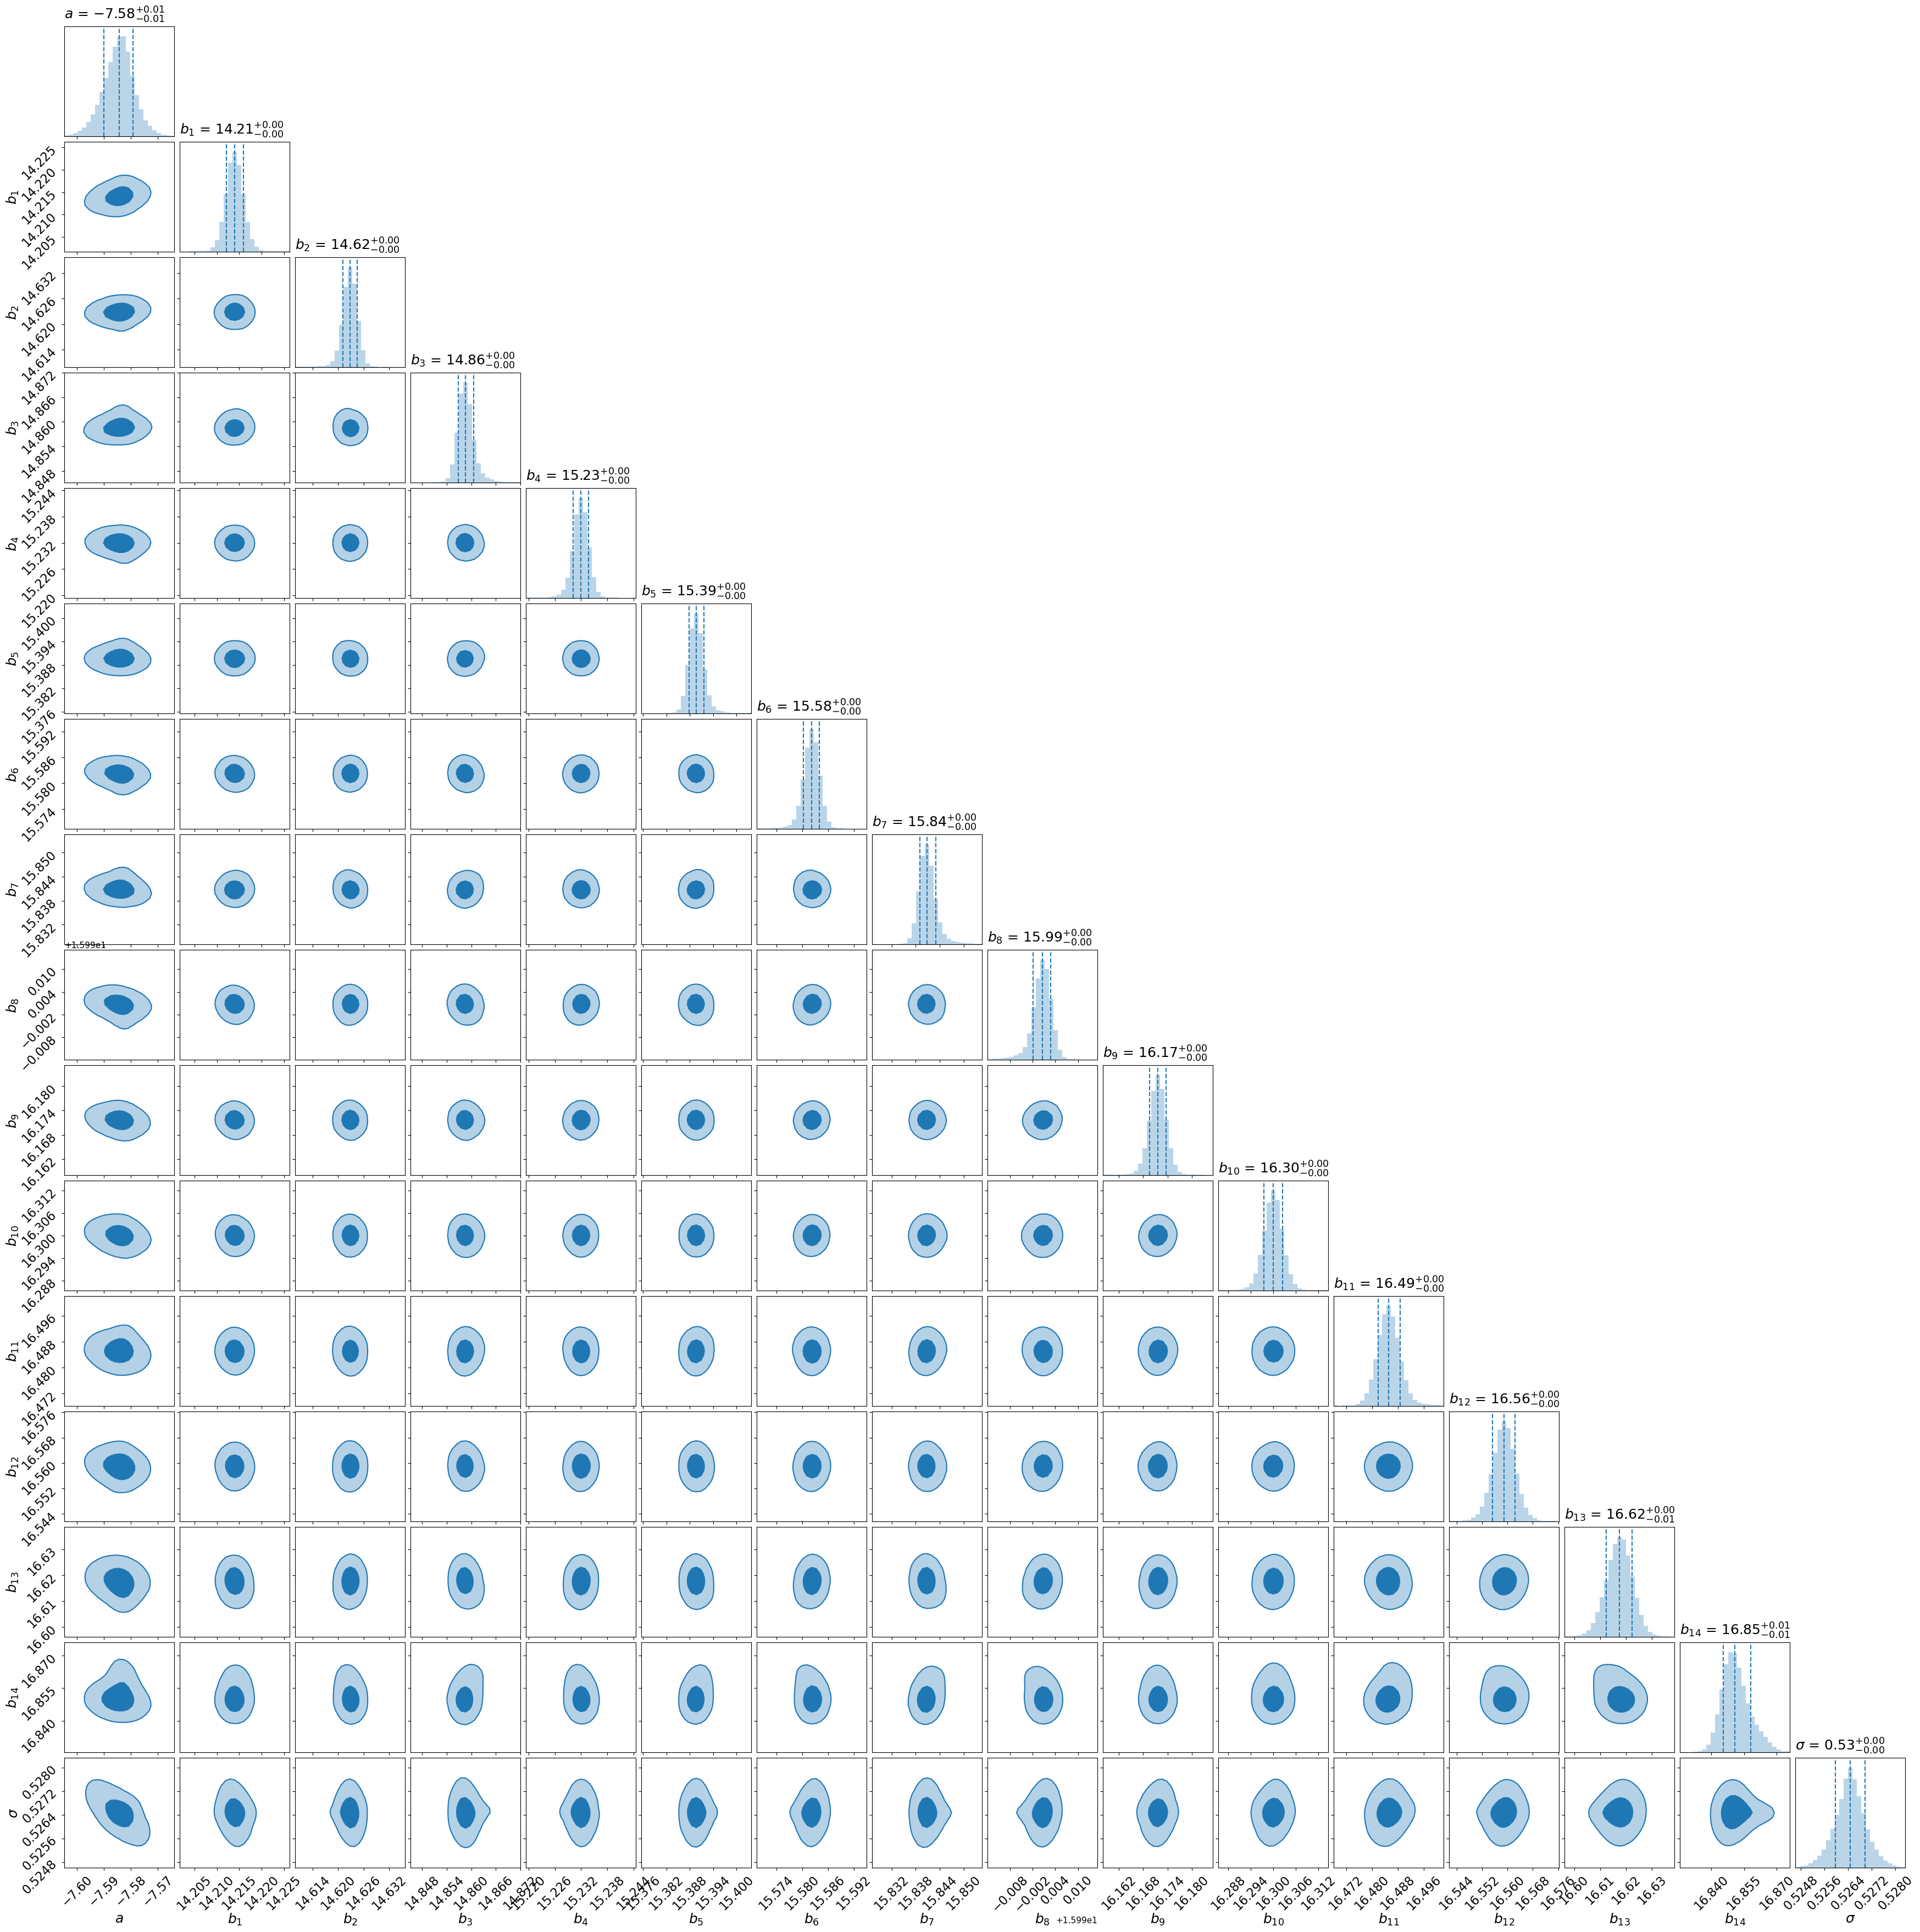

In [74]:
labels  = ['$a$']
labels += [f'$b_{{ {k+1} }}$' for k in np.arange(n_zbins)]
labels += [r'$\sigma$']

fig = corner(mcmc_samples.T, bins=25, smooth=1,
             range=limits,
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             truths=tf_par,
             truth_color='tab:green',
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16);

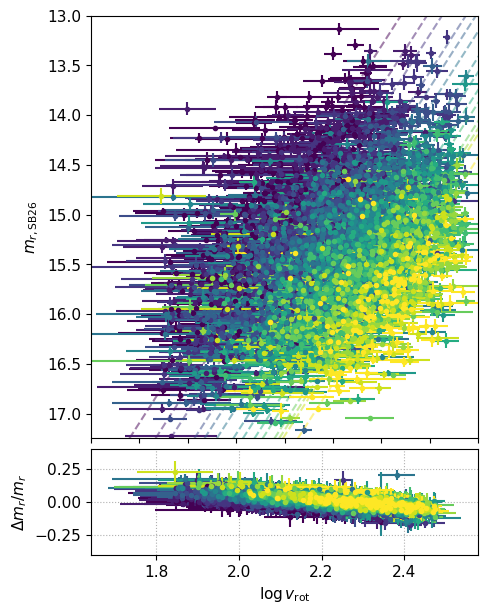

In [75]:
fig, axes = plt.subplots(2, 1, figsize=(5,7),
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

_logv = np.arange(0, 3, 0.1) - logV0

color = iter(plt.cm.viridis(np.linspace(0,1, n_zbins)))

for k in range(n_zbins):
    ax = axes[0]
    c = next(color)
    
    eb = ax.errorbar(x=logv[k] + logV0, y=mr[k],
                     xerr=dlogv[k], yerr=dmr[k],
                     fmt='.', color=c,
                     label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

    ax.plot(_logv + logV0, a_mcmc*_logv + b_mcmc[k], color=eb[0].get_color(), ls='--', alpha=0.5)

    ax = axes[1]
    logv_obs = logv[k]
    m_obs = mr[k]
    m_exp = a_mcmc*logv_obs + b_mcmc[k]
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp - m_obs)/m_exp,
                     xerr=dlogv[k], yerr=dmr[k],
                     fmt='.', color=c)

ax = axes[0]
ax.set(xlim=[1.7, 2.5],
       ylim=[17.25, 13],
       xticklabels=[],
       ylabel=r'$m_{r,\mathrm{SB26}}$')

ax = axes[1]
ax.grid(ls=':')

ax.set(xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$\Delta m_r/m_r$',
       ylim=(-0.4,0.4));

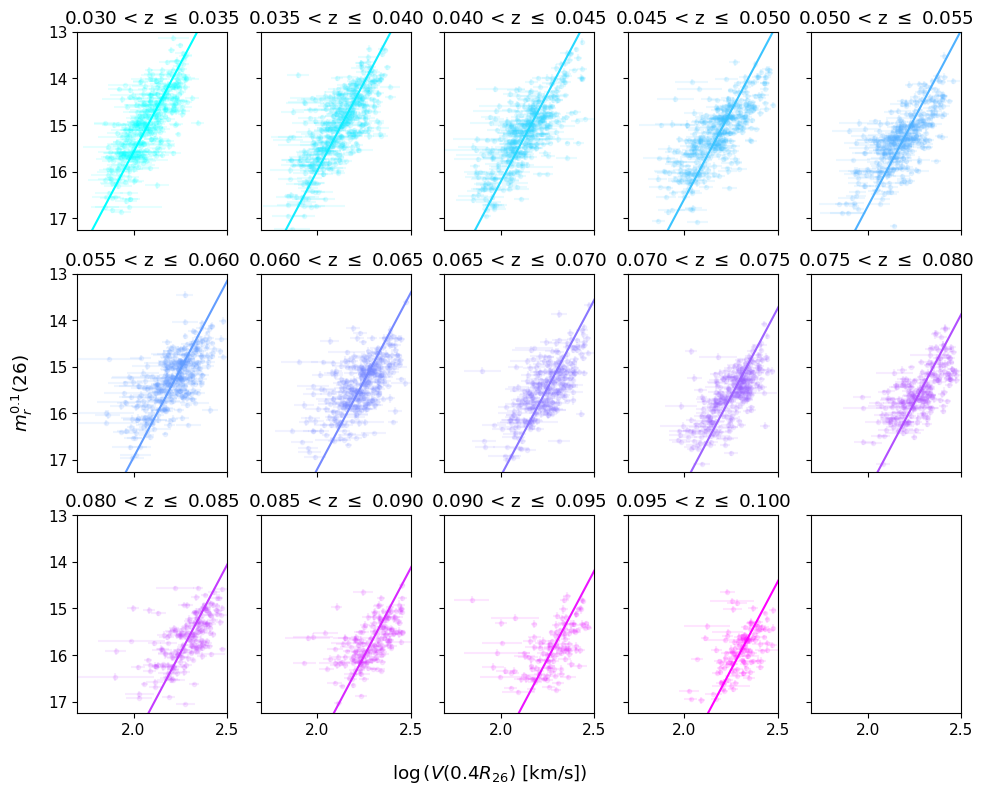

In [76]:
fig, axes = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1, n_zbins)))
for i in range(n_zbins):
    c = next(color)
    
    row = int(i/5)
    col = i%5
    
    eb = axes[row,col].errorbar(logv[i] + logV0, mr[i], xerr=dlogv[i], yerr=dmr[i], fmt='.', color=c, alpha=0.1)
    axes[row,col].plot(_logv + logV0, a_mcmc*_logv + b_mcmc[i], color=c)
    
    axes[row,col].set(xlim=[1.7, 2.5], ylim=[17.25, 13], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

#### Quick Check of Many Realizations of the "Calibration" Sample

In [42]:
bounds = [[-20, 0]]              # Bounds on a (slope)
bounds += n_zbins*[(-20, 20)]    # Bounds on b (intercepts: z-bins)
bounds += [(0,5)]                # Bounds on sigma

a_real, b_real, sigma_real = [], [], []

for i in tqdm(np.arange(25)):
    mock_downsample = downsample(mock, Ntfr)
    
    idx_mock_downsample_goodv = alex_cuts_velocity(mock_downsample, logv_name='LOGVROT_MOCK', distmod_name='MU_OBS_MOCK')
    idx_mock_downsample_notdwarf = alex_cuts_dwarf(mock_downsample, rmag_name='R_MAG_SB26_CORR', distmod_name='MU_OBS_MOCK')
    idx_mock_downsample_good = idx_mock_downsample_goodv & idx_mock_downsample_notdwarf

    zbin_idx = np.digitize(mock_downsample['zobs'], zbins, right=True)
    no_use = (zbin_idx == 0) | (zbin_idx == len(zbins))
    mock_downsample = downsample(mock_downsample[idx_mock_downsample_good & ~no_use], size=4200)
    
    zbin_idx = np.digitize(mock_downsample['zobs'], zbins, right=True)
    logV0_mock = np.median(mock_downsample['LOGVROT_MOCK'])

    datasets = [] # list of (2xN) arrays of the data
    covs = []     # covariance of zero point and slope for each "cluster"
    
    for j, _zbin_id in enumerate(_zbin_ids):
        select_zbin = np.isin(zbin_idx, _zbin_id)
    
        logv = mock_downsample['LOGVROT_MOCK'].to_numpy()[select_zbin] - logV0_mock
        dlogv = mock_downsample['LOGVROT_ERR_MOCK'].to_numpy()[select_zbin]
        mr = mock_downsample['R_MAG_SB26_CORR'].to_numpy()[select_zbin]
        dmr = mock_downsample['R_MAG_SB26_ERR_CORR'].to_numpy()[select_zbin]
    
        N = len(logv)
        cov = np.empty((2, 2, N))
        for k in range(N):
            cov[:,:,k] = np.array([[dlogv[k]**2, 0.], [0., dmr[k]**2]])
        covs.append(cov)
    
        data = np.empty((2, N))
        data[0] = logv
        data[1] = mr
        datasets.append(data)
    
    hf = MultiLinFit(datasets, covs, scatter=1)
    pars, parscatter, lnpost = hf.optimize(bounds)

    a_real.append(pars[0])
    b_real.append(pars[1:])
    sigma_real.append(parscatter[0])

100%|██████████| 25/25 [15:27<00:00, 37.09s/it]


In [43]:
# N = len(logvrot_mock)
# Ns = 150

# a_real, b_real, sigma_real = [], [], []

# for i in tqdm(np.arange(100)):
#     idx = np.random.choice(N-1, size=Ns, replace=False)

#     logV0_mock = np.median(logvrot_mock)

#     logv  = logvrot_mock[idx] - logV0_mock
#     dlogv = logvrot_err_mock[idx]
#     Mr  = Mr_obs_mock[idx]
#     dMr = Mr_obs_err_mock[idx]
#     weights = np.ones_like(logv)
#     # weights = 1/mock['MAX_VOL_FRAC'].to_numpy()[idx]
    
#     mock_dat = np.empty((2, Ns))
#     mock_cov = np.empty((2, 2, Ns))
    
#     logv, Ns, len(logv)
    
#     for k in range(Ns):
#         mock_dat[:, k] = np.array([logv[k], Mr[k]])
#         mock_cov[:,:,k] = np.array([[dlogv[k]**2, 0.], [0., dMr[k]**2]])
    
#     bounds = [[-20, 0]]                    # Bounds on a (slope)
#     bounds += [(-40,0)]                    # Bounds on b (intercepts: 0-pt + clusters)
#     bounds += [(0,5)]                      # Bounds on sigma
    
#     # logging.warning('Fit does not account for volume weights.')
    
#     hf = LinFit(mock_dat, mock_cov, weights=weights)
#     (a_bf, b_bf), sigma_bf, ll_bf = hf.optimize(bounds, verbose=False)

#     a_real.append(a_bf)
#     b_real.append(b_bf),
#     sigma_real.append(sigma_bf)
    
#     # print(f'a = {a_bf:.3f}')
#     # print(f'b = {b_bf:.3f}')
#     # print(f'sigma = {sigma_bf:.3f}')

[Text(0.5, 1.0, '$\\hat{\\sigma}=0.56\\pm0.01$'),
 Text(0.5, 0, 'magnitude scatter $\\sigma$')]

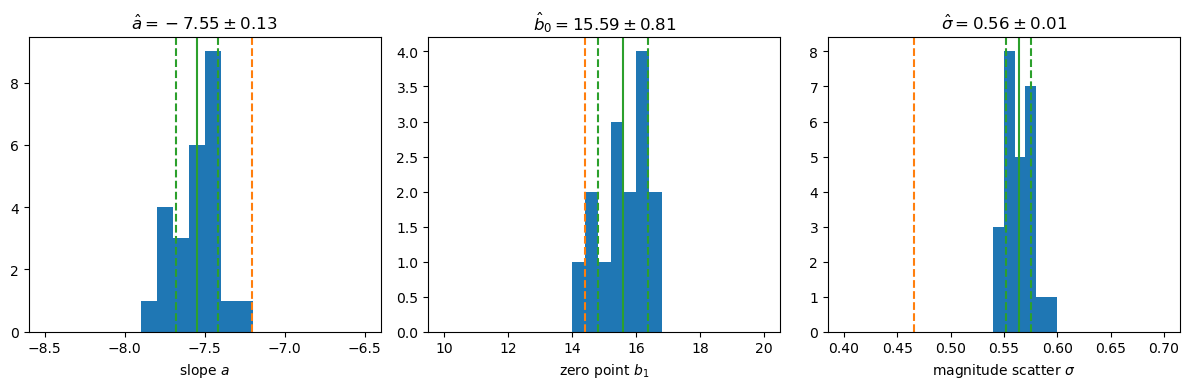

In [44]:
fig, axes = plt.subplots(1,3, figsize=(12,4), tight_layout=True)

ax = axes[0]
ax.hist(a_real, bins=np.arange(-8.5,-6.4,0.1))
ax.axvline(tf_par[0], color='tab:orange', ls='--')
ax.axvline(np.mean(a_real), color='tab:green')
ax.axvline(np.mean(a_real) - np.std(a_real), color='tab:green', ls='--')
ax.axvline(np.mean(a_real) + np.std(a_real), color='tab:green', ls='--')
ax.set(title=rf'$\hat{{a}}={np.mean(a_real):.2f}\pm{np.std(a_real):.2f}$',
       xlabel=r'slope $a$')

ax = axes[1]
ax.hist(b_real[0], bins=np.arange(10,20.4,0.4))
ax.axvline(tf_par[1], color='tab:orange', ls='--')
ax.axvline(np.mean(b_real[0]), color='tab:green')
ax.axvline(np.mean(b_real[0]) - np.std(b_real[0]), color='tab:green', ls='--')
ax.axvline(np.mean(b_real[0]) + np.std(b_real[0]), color='tab:green', ls='--')
ax.set(title=rf'$\hat{{b}}_0={np.mean(b_real[0]):.2f}\pm{np.std(b_real):.2f}$',
       xlabel=r'zero point $b_1$')

ax = axes[2]
ax.hist(sigma_real, bins=np.arange(0.4,0.71,0.01))
ax.axvline(tf_par[-1], color='tab:orange', ls='--')
ax.axvline(np.mean(sigma_real), color='tab:green')
ax.axvline(np.mean(sigma_real) - np.std(sigma_real), color='tab:green', ls='--')
ax.axvline(np.mean(sigma_real) + np.std(sigma_real), color='tab:green', ls='--')
ax.set(title=rf'$\hat{{\sigma}}={np.mean(sigma_real):.2f}\pm{np.std(sigma_real):.2f}$',
       xlabel=r'magnitude scatter $\sigma$')

# fig.set_facecolor('none')
# fig.savefig(f'tfr_fit_param_spread_equal_weight_{os.path.basename(mockfile)[:-9]}.png', dpi=150)
# # fig.savefig('tfr_fit_param_spread_error_weighted.png', dpi=150)
# # fig.savefig('tfr_fit_param_spread_var_weighted.png', dpi=150)

In [45]:
a_avg = np.average(a_real)
b_avg = np.average(b_real, axis=0)
sigma_avg = np.average(sigma_real)
a_avg, b_avg, sigma_avg

(-7.547292470139067,
 array([14.02817984, 14.38147753, 14.67708831, 14.92909821, 15.17107474,
        15.36445431, 15.556077  , 15.73447915, 15.91482812, 16.04973313,
        16.21838628, 16.36289338, 16.47565253, 16.58060629, 16.69672537]),
 0.56391878651275)

In [46]:
a_mcmc, b_mcmc, sigma_mcmc = a_avg, b_avg, sigma_avg

#### Apply Velocity and Dwarf Identification to the Full Sample

In [48]:
idx_mock_goodv = alex_cuts_velocity(mock, logv_name='LOGVROT_MOCK', distmod_name='MU_OBS_MOCK')
idx_mock_notdwarf = alex_cuts_dwarf(mock, rmag_name='R_MAG_SB26_CORR', distmod_name='MU_OBS_MOCK')
idx_mock_good = idx_mock_goodv & idx_mock_notdwarf

mock['DWARF'] = np.zeros_like(mock['LOGVROT_MOCK'], dtype=bool)
mock.loc[~idx_mock_notdwarf, 'DWARF'] = True

mock['MAIN'] = np.zeros_like(mock['DWARF'], dtype=bool)
mock.loc[idx_mock_good, 'MAIN'] = True

In [49]:
len(mock), np.sum(mock['MAIN'])

(203127, 165129)

In [50]:
# Identify zbins for all mock galaxies
zbin_idx = np.digitize(mock['zobs'], zbins, right=True)

### Compute TFR Distance Modulus

Using the "measured" apparent magnitude and the TFR-predicted absolute magnitude from the "calibration" above, compute the distance modulus:

$$
\mu_\mathrm{TF} =  m_{r,\mathrm{SB_{26}}} - M_{r,\mathrm{TF}}.
$$

Also compute the log distance ratio

$$
\eta = \log{\left(\frac{D_z}{D_\mathrm{TFR}}\right)}
$$

In [51]:
#- Compute TF absolute magnitude and uncertainties using the MCMC from HyperFit.
#  Downsample the MCMC significantly for this quick calculation.

# Redshift bin centers:
zc = 0.5*dz + zbins[:-1]
mu_zc = cosmology.distmod(zc)

# Convert each redshift bin zero point to an abs mag
B_mcmc = b_mcmc - mu_zc.value

# Compute indices for intercepts.
# For galaxies outside the calibration range, assign them to the closest bin.
B_idx = zbin_idx - 1
B_idx[zbin_idx == 0] = 0
B_idx[zbin_idx == len(zbins)] = len(zbins) - 2

# Use the calibrated TFR to compute abs mag.
logV0_mock = np.median(mock['LOGVROT_MOCK'])
Mr_TF = a_mcmc * (mock['LOGVROT_MOCK'] - logV0_mock) + B_mcmc[B_idx]

# Compute the uncertainty in TFR abs mag.
Mr_TF_err = np.zeros_like(Mr_TF)

for i in tqdm(range(len(mock))):
    logv_random = np.random.normal(mock['LOGVROT_MOCK'].iloc[i], 0.434*mock['LOGVROT_ERR_MOCK'].iloc[i], size=1000)
    Mr_stat = a_mcmc*(logv_random - logV0_mock) + B_mcmc[B_idx[i]]
    Mr_TF_err[i] = np.sqrt(np.nanstd(Mr_stat)**2 + sigma_mcmc**2)

# Mr_TF = a_mcmc * (logvrot_mock - logV0_mock) + b_mcmc
# a_sampled, b_sampled = mcmc_samples[0][::500], mcmc_samples[1][::500]
# Mr_TF_err = np.std(a_sampled * (logvrot_mock[:, np.newaxis] - logV0_mock) + b_sampled, axis=1)

mu_TF = mock['R_MAG_SB26_CORR'] - Mr_TF
mu_TF_err = np.sqrt(mock['R_ABSMAG_SB26_ERR_MOCK']**2 + Mr_TF_err**2)

mu_zcmb = cosmology.distmod(mock['zobs']).to_value('mag')
mu_zcos = cosmology.distmod(mock['zcos']).to_value('mag')

eta_true = 0.2 * (mu_zcmb - mu_zcos)
eta_mock = 0.2 * (mu_zcmb - mu_TF)
eta_err_mock = 0.2 * mu_TF_err

100%|██████████| 203127/203127 [00:25<00:00, 7929.61it/s]


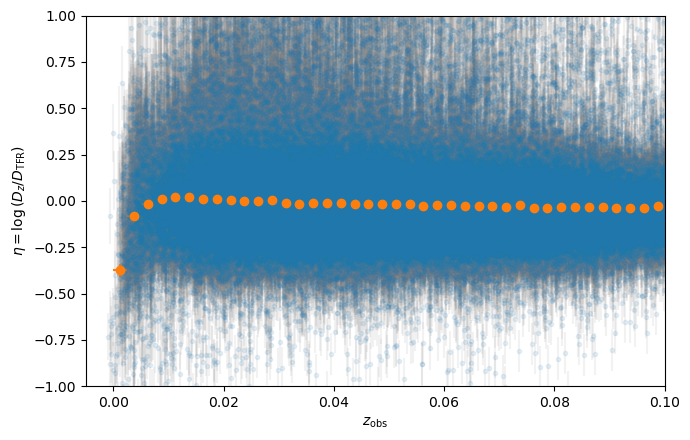

In [52]:
fig, ax = plt.subplots(1,1, figsize=(7,4.5), tight_layout=True)
ax.errorbar(mock['zobs'], eta_mock,
            yerr=eta_err_mock,
            fmt='.',
            alpha=0.1,
            ecolor='gray')

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

_, eta_avg, eta_std = profile_histogram(mock['zobs'], eta_mock, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')

ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$');

fig.set_facecolor('none')
# fig.savefig('tfr_mock_eta.png', dpi=150);

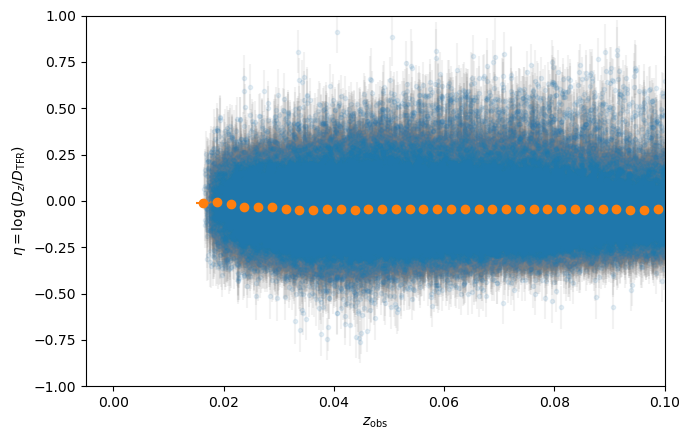

In [53]:
fig, ax = plt.subplots(1,1, figsize=(7,4.5), tight_layout=True)
ax.errorbar(mock['zobs'][idx_mock_good], eta_mock[idx_mock_good],
            yerr=eta_err_mock[idx_mock_good],
            fmt='.',
            alpha=0.1,
            ecolor='gray')

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

_, eta_avg, eta_std = profile_histogram(mock['zobs'][idx_mock_good], eta_mock[idx_mock_good], zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')

ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$');

fig.set_facecolor('none')

/tmp/ipykernel_2146505/1790439695.py:1: RuntimeWarning: invalid value encountered in log10
  logdist_true = np.log10(cosmology.comoving_distance(mock['zobs'].to_numpy()).value/cosmology.comoving_distance(mock['zcos'].to_numpy()).value)


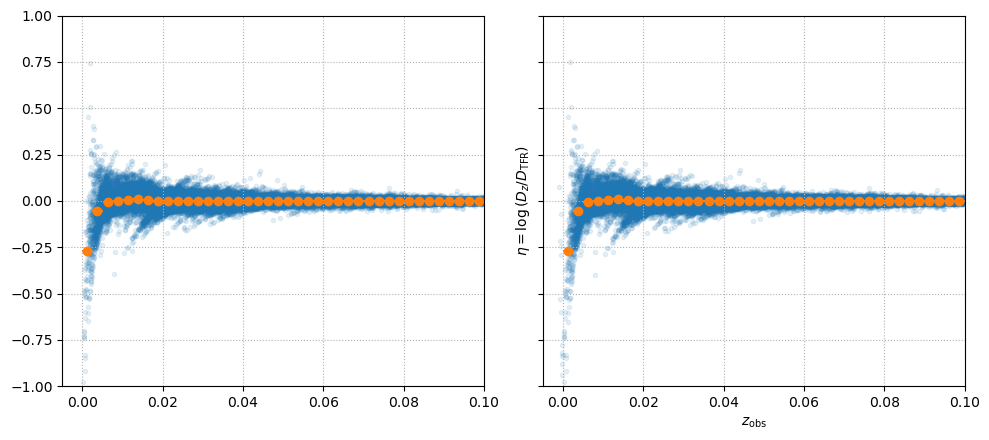

In [54]:
logdist_true = np.log10(cosmology.comoving_distance(mock['zobs'].to_numpy()).value/cosmology.comoving_distance(mock['zcos'].to_numpy()).value)

fig, axes = plt.subplots(1,2, figsize=(10,4.5), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.scatter(mock['zobs'], logdist_true, marker='.', alpha=0.1)

ax = axes[1]
ax.scatter(mock['zobs'], eta_true, marker='.', alpha=0.1)

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

ax = axes[0]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], logdist_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')
ax.grid(ls=':')

ax = axes[1]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], eta_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')

ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$')
ax.grid(ls=':');

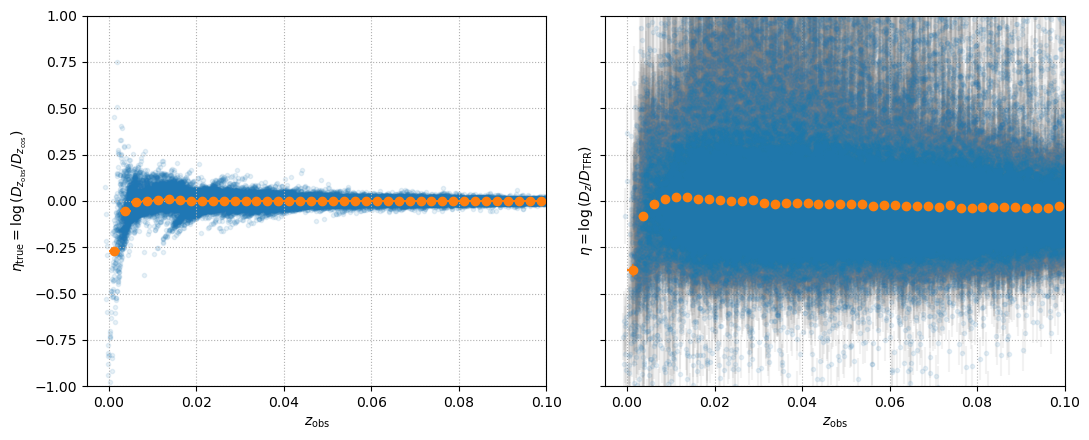

In [55]:
fig, axes = plt.subplots(1,2, figsize=(11,4.5), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.scatter(mock['zobs'], eta_true, marker='.', alpha=0.1)

ax = axes[1]
ax.errorbar(mock['zobs'], eta_mock, yerr=eta_err_mock, fmt='.', alpha=0.1, ecolor='gray')

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

ax = axes[0]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], eta_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')
ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta_\mathrm{true} = \log{(D_{z_\mathrm{obs}} / D_{z_\mathrm{cos}})}$')
ax.grid(ls=':')

ax = axes[1]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], eta_mock, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')
ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$')
ax.grid(ls=':');

fig.set_facecolor('none')
# fig.savefig('tfr_mock_eta_true_mock.png', dpi=150);

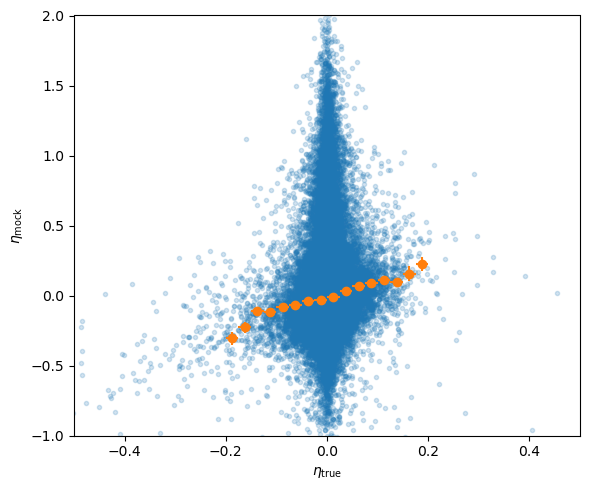

In [56]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)

ax.scatter(eta_true, eta_mock, alpha=0.2, marker='.')

eta_bins = np.arange(-0.2, 0.225, 0.025)
eta_c = 0.5*(eta_bins[1:] + eta_bins[:-1])
deta = 0.5*np.diff(eta_bins)
_, eta_avg, eta_std = profile_histogram(eta_true, eta_mock, eta_bins)

ax.errorbar(eta_c, eta_avg, xerr=deta, yerr=eta_std, fmt='o', color='tab:orange')

ax.set(xlim=(-0.5,0.5),
       xlabel=r'$\eta_\mathrm{true}$',
       ylim=(-1,2),
       ylabel=r'$\eta_\mathrm{mock}$');

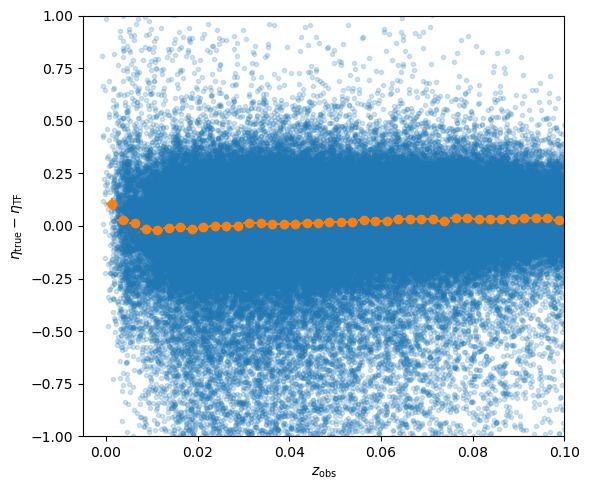

In [57]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)

ax.scatter(mock['zobs'], eta_true - eta_mock, alpha=0.2, marker='.')

_, deta_avg, deta_std = profile_histogram(mock['zobs'], eta_true - eta_mock, zbins)
ax.errorbar(zc, deta_avg, xerr=dz, yerr=deta_std, fmt='o', color='tab:orange')

ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta_\mathrm{true} - \eta_\mathrm{TF}$');

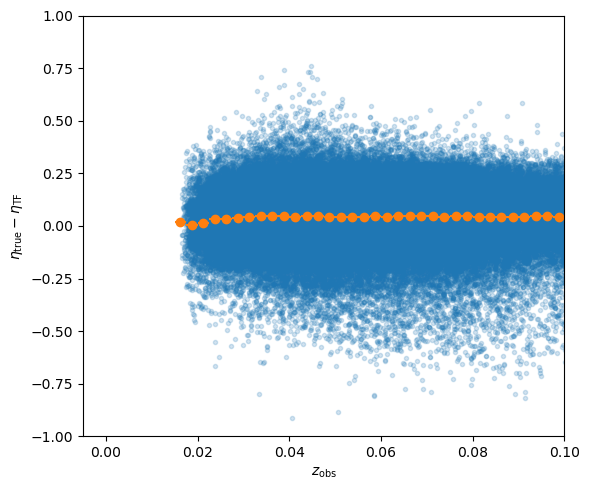

In [58]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)

ax.scatter(mock['zobs'][idx_mock_good], eta_true[idx_mock_good] - eta_mock[idx_mock_good], alpha=0.2, marker='.')

_, deta_avg, deta_std = profile_histogram(mock['zobs'][idx_mock_good], eta_true[idx_mock_good] - eta_mock[idx_mock_good], zbins)
ax.errorbar(zc, deta_avg, xerr=dz, yerr=deta_std, fmt='o', color='tab:orange')

ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta_\mathrm{true} - \eta_\mathrm{TF}$');

In [59]:
# fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)
# ax.hist((eta_mock - eta_true) / eta_err_mock, bins=np.arange(-10,10.2,0.2))
# ax.set(xlabel=r'$(\eta_\mathrm{mock} - \eta_\mathrm{true})/\sigma_\eta$',
#        yscale='log')

## Write Output to FITS

In [60]:
{ 'a' : a_mcmc} | \
{ f'b{k+1}' : b_mcmc[k] for k in range(len(b_mcmc)) } | \
{ 'sigma' : sigma_mcmc }

{'a': -7.547292470139067,
 'b1': 14.028179839837865,
 'b2': 14.381477525225264,
 'b3': 14.677088311555897,
 'b4': 14.929098212376655,
 'b5': 15.171074744259126,
 'b6': 15.36445430844873,
 'b7': 15.55607699930154,
 'b8': 15.734479146041483,
 'b9': 15.91482811954271,
 'b10': 16.04973313425589,
 'b11': 16.21838628435468,
 'b12': 16.36289338470726,
 'b13': 16.475652527025378,
 'b14': 16.58060628729527,
 'b15': 16.6967253723513,
 'sigma': 0.56391878651275}

In [62]:
outfile = os.path.join('/global/cfs/cdirs/desi/science/td/pv/mocks/TF_mocks/fullmocks/v0.5.4',
                       os.path.basename(mockfile).replace('.dat.hdf5', '.fits').replace('BGS_PV', 'TF'))

# hdr = fits.Header(dict(NTF=len(mock),
#                        a=a_mcmc,
#                        b=b_mcmc,
#                        sigma=sigma_mcmc,
#                        cov_aa=cov_mcmc[0][0],
#                        cov_ab=cov_mcmc[0][1],
#                        cov_as=cov_mcmc[0][2],
#                        cov_bb=cov_mcmc[1][1],
#                        cov_bs=cov_mcmc[1][2],
#                        cov_ss=cov_mcmc[2][2]))

hdr = fits.Header({ 'NTF' : len(mock) } | \
                  { 'a' : a_mcmc } | \
                  { f'b{k+1}' : b_mcmc[k] for k in range(len(b_mcmc)) } | \
                  { 'sigma' : sigma_mcmc })      

col01 = fits.Column(name='RA',            format='D', array=mock['ra'].to_numpy())
col02 = fits.Column(name='DEC',           format='D', array=mock['dec'].to_numpy())
col03 = fits.Column(name='ZOBS',          format='D', array=mock['zobs'].to_numpy())
col04 = fits.Column(name='ZCOS',          format='D', array=mock['zcos'].to_numpy())
col05 = fits.Column(name='vx',            format='D', array=mock['vx'].to_numpy())
col06 = fits.Column(name='vy',            format='D', array=mock['vy'].to_numpy())
col07 = fits.Column(name='vz',            format='D', array=mock['vz'].to_numpy())
col08 = fits.Column(name='DWARF',         format='L', array=mock['DWARF'].to_numpy())
col09 = fits.Column(name='MAIN',          format='L', array=mock['MAIN'].to_numpy())
col10 = fits.Column(name='LOGVROT',       format='D', array=mock['LOGVROT_MOCK'].to_numpy())
col11 = fits.Column(name='R_ABSMAG_SB26', format='D', array=mock['R_ABSMAG_SB26_MOCK'].to_numpy())
col12 = fits.Column(name='LOGDIST_TRUE',  format='D', array=eta_true)
col13 = fits.Column(name='LOGDIST',       format='D', array=eta_mock.to_numpy())
col14 = fits.Column(name='LOGDIST_ERR',   format='D', array=eta_err_mock.to_numpy())
col15 = fits.Column(name='Y1_COMP',       format='D', array=mock['Y1_COMP'].to_numpy())
col16 = fits.Column(name='Y3_COMP',       format='D', array=mock['Y3_COMP'].to_numpy())

hdulist = fits.BinTableHDU.from_columns([col01, col02, col03, col04, col05,
                                         col06, col07, col08, col09, col10,
                                         col11, col12, col13, col14, col15,
                                         col16],
                                        header=hdr)
hdulist.writeto(outfile, overwrite=True)

shutil.chown(outfile, group='desi')

In [ ]:
# !jupyter nbconvert --to script TFR_mock_gen_v13.ipynb